# TransactionSentinel: Proteção inteligente contra fraudes em transações de cartão de crédito.


* Este notebook apresenta a construção de um estudo e um modelo de ML para detecção de fraudes em dados financeiros fictícios, seguindo a metodologia CRISP-DM.

* A abordagem será estruturada em cinco das seis etapas da metodologia. A etapa de Deploy (Implantação) não será totalmente executada; no entanto, o modelo será salvo como se estivesse pronto para produção.
    * Etapas: 

        * **Compreensão do Negócio** – Definição do problema e dos objetivos do projeto.

        * **Compreensão dos Dados** – Exploração inicial para entender a estrutura e qualidade dos dados.

        * **Preparação dos Dados** – Tratamento, limpeza e transformação dos dados para a modelagem.

        * **Modelagem** – Aplicação de algoritmos de machine learning para detectar padrões de fraude.

        * **Avaliação** – Medição do desempenho do modelo para garantir sua eficácia.

        * **Deploy** (Implantação) – Integração do modelo em um ambiente operacional para uso real.

# 1.Compreensão do Negócio

* A detecção de fraudes em transações financeiras é um desafio essencial para instituições bancárias e operadoras de cartões de crédito. A identificação eficiente de fraudes reduz perdas financeiras e protege clientes contra atividades fraudulentas.

* Objetivo do Projeto:

    * 1- Desenvolver uma análise exploratória que forneça informações sobre o comportamento dos eventos fraudulentos e não fraudulentos. 

    * 2-Desenvolver um modelo de Machine Learning capaz de identificar transações fraudulentas com alto desempenho, garantindo um equilíbrio entre segurança e experiência do usuário.



        * O modelo será avaliado com as seguintes métricas:

        * **Recall ≥ 70% ** – Para minimizar a quantidade de fraudes não detectadas.

        * ** AUC-ROC ≥ 85% ** – Para garantir uma boa distinção entre transações legítimas e fraudulentas.

        * ** F1-score ≥ 74% ** – Para garantir um bom equilíbrio entre precisão e recall, considerando a importância de minimizar tanto os falsos positivos quanto os falsos negativos.

* Restrições de Negócio

    Para atender a requisitos e garantir um modelo confiável:

    * Imparcialidade e Prevenção de Discriminação: 
    
        O modelo não deve apresentar tendências discriminatórias baseadas em atributos como gênero, idade, localização ou outros fatores socioeconômicos. Se esse tipo de varivel for interessante ao evento em estudo, deve se aplicar transformacoes nessas variaveis para que seja mitigada chance de vies descriminativo, ex: idade pode ser transformada em faixas etarias, localizacao pode se tornar distancia entre residencia do titular e local do estabelecimento (verificando distancia de tempo entre duas ou mais transacoes) para identificar algum padrao nas fraudes. 

 


    * Explicabilidade e Transparência

        O modelo deve ser interpretável tanto globalmente quanto localmente, garantindo que especialistas possam entender seus critérios de decisão. Técnicas como SHAP (SHapley Additive Explanations) e LIME (Local Interpretable Model-agnostic Explanations) serão aplicadas para fornecer insights sobre as previsões do modelo.

* Escopo da Implantação
    * O modelo final será salvo para futuras implementações, mas a fase de Deploy não será completamente executada neste estudo.



# 2.Compreensão dos Dados

In [1]:
#Bibliotecas
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import warnings
from scipy.stats import chi2_contingency
import plotly.express as px
import plotly.graph_objects as go

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score,average_precision_score
import optuna
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef

from category_encoders import WOEEncoder

from scipy.stats import ttest_ind


# Técnicas de oversampling
from imblearn.over_sampling import (
    SMOTE,               # SMOTE padrão
    ADASYN,              # SMOTE adaptativo
    BorderlineSMOTE,     # SMOTE focado na fronteira
    KMeansSMOTE          # SMOTE com KMeans
)

# Técnicas combinadas com undersampling
from imblearn.combine import (
    SMOTEENN,            # SMOTE + Edited Nearest Neighbors
    SMOTETomek           # SMOTE + Tomek Links
)


from imblearn.over_sampling import SMOTE, ADASYN, KMeansSMOTE, BorderlineSMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN




* Importando e conhecendo os dados inicialmente

In [2]:
############para Kaggle

# Load the training dataset
#train_data = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv') 

# Load the testing dataset
#test_data = pd.read_csv('/kaggle/input/fraud-detection/fraudTest.csv')

# Display the first few rows of both datasets
#print("First 5 rows of the training dataset:")
#print(train_data.head())

#print("\nFirst 5 rows of the testing dataset:")
#print(test_data.head())


# Carregando arquivos em parquet
df_orig_train = pd.read_parquet('C:/Users/jgeov/OneDrive/Documentos/GitHub/Ciencia_de_dados-1/Fraud_detection/fraudTrain.parquet')
df_orig_test = pd.read_parquet('C:/Users/jgeov/OneDrive/Documentos/GitHub/Ciencia_de_dados-1/Fraud_detection/fraudTest.parquet')



In [3]:
print('df_treino dimensões:', f"{df_orig_train.shape[0]:,}".replace(',', '.') + ' linhas, ' + f"{df_orig_train.shape[1]:,}".replace(',', '.') + ' colunas')
print('')
print('df_teste dimensões:', f"{df_orig_test.shape[0]:,}".replace(',', '.') + ' linhas, ' + f"{df_orig_test.shape[1]:,}".replace(',', '.') + ' colunas')
print('')
print('Total de observações:', f"{df_orig_train.shape[0] + df_orig_test.shape[0]:,}".replace(',', '.'))


df_treino dimensões: 1.296.675 linhas, 23 colunas

df_teste dimensões: 555.719 linhas, 23 colunas

Total de observações: 1.852.394


In [4]:
# Se você quiser combiná-los (por exemplo, por concatenação)
df_total = pd.concat([df_orig_train, df_orig_test], ignore_index=True)

# Exibindo as primeiras linhas do DataFrame combinado

#configs para nao quebrar linhas no print do  df
pd.set_option('display.expand_frame_repr', False) 
pd.set_option('display.max_columns', None)


df_total.head(3)


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0


In [5]:
#A coluna "Unnamed: 0" representa apenas a contagem dos datasets de treino e teste. Ao concatená-los para a compreensão dos dados, essa coluna foi duplicada.
#Como se trata apenas de um índice sem valor informativo para a análise, e não será utilizada em nenhuma etapa do estudo, ela será removida já nesta fase.
df_total.sort_values(by="Unnamed: 0", ascending=True).head(5)


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
1296675,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1296676,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0


In [6]:
#removendo 
df_total = df_total.drop(columns=["Unnamed: 0"])

#resetando indice (morrer de certeza, depois da concatenacao pode ter duplicado tambem em algum ponto)
df_total = df_total.reset_index(drop=True)

#ordenando os dados pelo indice
df_total = df_total.sort_index(ascending=True)


df_total.head(5)


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [7]:
print('df_total dimesoes:',df_total.shape) #comparacao com soma dos dfs de treino e teste (soma bate) ok

df_total dimesoes: (1852394, 22)


In [8]:
#cnhecendo as colunas e tipos de dados
print(df_total.columns)
print("")
print(df_total.dtypes)

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud              

In [9]:
#checando os valores null em cada variavel 

#checando se há valores nulos 
df_total.isnull().sum()  
#valores nulos nao encontrados 

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [10]:
#contando a quantidade de zeros em cada coluna para verificar se elas tem 
# informacao suficiente para entrar no modelo futuramente

for col in df_total.columns:
    zero_count = (df_total[col] == 0).sum()
    print("")
    print(f" '{col}': {zero_count} valores zero")

    #nenhuma variavel contem valores zerados, a nao ser a variavel alvo,
    #  e aqui ja podemos ver que se trata de um estudo de enventos raros realmente. 




 'trans_date_trans_time': 0 valores zero

 'cc_num': 0 valores zero

 'merchant': 0 valores zero

 'category': 0 valores zero

 'amt': 0 valores zero

 'first': 0 valores zero

 'last': 0 valores zero

 'gender': 0 valores zero

 'street': 0 valores zero

 'city': 0 valores zero

 'state': 0 valores zero

 'zip': 0 valores zero

 'lat': 0 valores zero

 'long': 0 valores zero

 'city_pop': 0 valores zero

 'job': 0 valores zero

 'dob': 0 valores zero

 'trans_num': 0 valores zero

 'unix_time': 0 valores zero

 'merch_lat': 0 valores zero

 'merch_long': 0 valores zero

 'is_fraud': 1842743 valores zero


# 2.1 Analisando e Descrevendo: Análise Exploratória (EDA)


* Dicionario de dados e acoes previamente ja determinadas de acordo com a natureza da varivel. 
* O oficial nao foi divulgado, entao com base no nome das variaveis foi determinado: 



| **Nome da Variável**        | **Descrição**                                                                 | **Transformação Necessária** |
|-----------------------------|-------------------------------------------------------------------------------|-----------------------------|
| **trans_date_trans_time**    | Data e hora da transação (`yyyy-mm-dd hh:mm:ss`).                            | Extrair hora, dia da semana, mês, periodo da transacao etc.|
| **cc_num** | Número do cartão de crédito utilizado na transação.<br> Pode ser útil para identificar padrões de uso suspeitos e anomalias.<br> Contudo, é um dado sensível e deve ser tratado para garantir conformidade com normas de privacidade. |  Extrair padrões relevantes, como:<br>  - Extrair primeiros dígitos (BIN) que identificam o banco das transações <br>  - Contagem de transações por cartão em um período de tempo. <br> - Contagem de vezes que o cartao foi usado|
| **merchant**                 | Nome do comerciante.                                                          |  |
| **category**                 | Categoria da transação (`misc_net`, `grocery_pos`, etc.).                     |  |
| **amt**                      | Valor da transação.                                                           |  |
| **first**                    | Primeiro nome do titular.                                                     | Remover (Irrelevante). |
| **last**                     | Sobrenome do titular.                                                         | Remover (Irrelevante). |
| **gender**                   | Gênero do titular (`F` ou `M`).                                               | Remover (Possível viés discriminatório).|
| **street**                   | Endereço do titular.                                                          | Remover (Irrelevante). |
| **city**                     | Cidade do titular.                                                            | Remover (Já há `lat` e `long`). |
| **state**                    | Estado do titular.                                                            | Remover (Já há `lat` e `long`). |
| **zip**                      | Código postal (CEP).                                                          | Remover (Já há `lat` e `long`). |
| **lat**                      | Latitude da localização do titular.                                           |  |
| **long**                     | Longitude da localização do titular.                                          |  |
| **city_pop**                 | População da cidade do titular.                                               |  |
| **job**                      | Profissão do titular.                                                         |  |
| **dob**                      | Data de nascimento (`yyyy-mm-dd`).                                            | Converter para idade. |
| **trans_num**                | Identificador único da transação.                                             | Remover (Irrelevante). |
| **unix_time**                | Timestamp Unix (segundos desde 1970).                                         | Remover - reduntande ja temos trans_date_trans_time  |
| **merch_lat**                | Latitude da localização do comerciante.                                       |  |
| **merch_long**               | Longitude da localização do comerciante.                                      |  |
| **is_fraud**                 | Indicador de fraude (`1` = fraudulenta, `0` = legítima).                      | **Variável alvo** |



In [11]:
print(df_total.dtypes)

df_anl_num = df_total.select_dtypes(include=[np.number])

pd.options.display.float_format = '{:.2f}'.format  # config 2 casas decimais para configurar o describe
df_anl_num.describe()

trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object


,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00
mean,417386038393710400.00,70.06,48813.26,38.54,-90.23,88643.67,1358674218.83,38.54,-90.23,0.01
std,1309115265318734848.00,159.25,26881.85,5.07,13.75,301487.62,18195081.39,5.11,13.76,0.07
min,60416207185.00,1.00,1257.00,20.03,-165.67,23.00,1325376018.00,19.03,-166.67,0.00
25%,180042946491150.00,9.64,26237.00,34.67,-96.80,741.00,1343016823.75,34.74,-96.90,0.00
50%,3521417320836166.00,47.45,48174.00,39.35,-87.48,2443.00,1357089331.00,39.37,-87.44,0.00
75%,4642255475285942.00,83.10,72042.00,41.94,-80.16,20328.00,1374581485.25,41.96,-80.25,0.00
max,4992346398065154048.00,28948.90,99921.00,66.69,-67.95,2906700.00,1388534374.00,67.51,-66.95,1.00


* Verificando relacao entre a variavel alvo e as variaveis explicativas numericas
    * sem muita correlacao inicialmente 

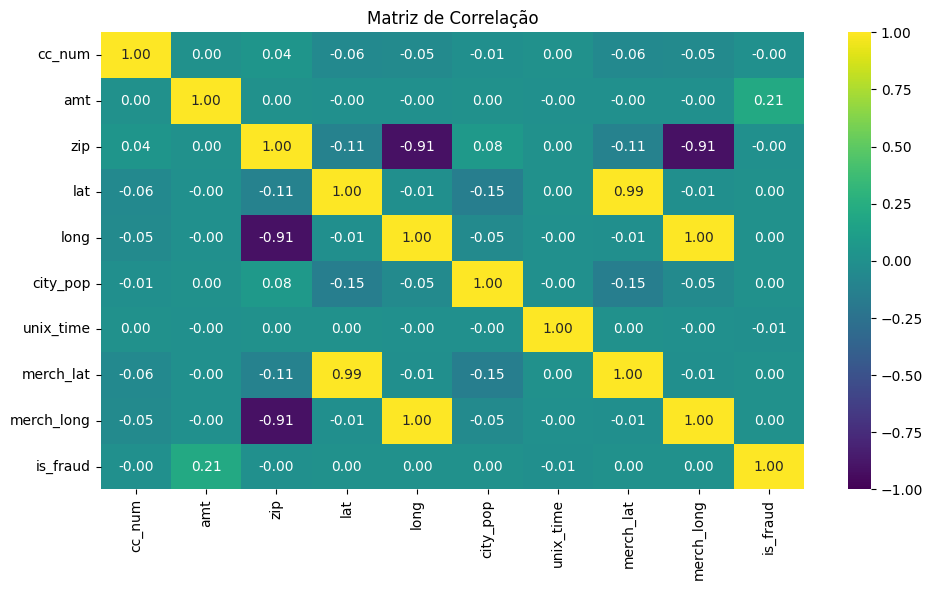

In [12]:
# Suprimir todos os warnings
warnings.filterwarnings("ignore")

# Criar a figura com 1 subgráfico (apenas o gráfico de correlação)
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

# 1. Gráfico de Correlação (Matriz de Correlação)
sns.heatmap(df_anl_num.corr(), annot=True, cmap="viridis", fmt=".2f", ax=axes, vmin=-1, vmax=1)
axes.set_title('Matriz de Correlação')

# Ajustar o layout
plt.tight_layout()
plt.show()




* Verificando relacao entre a variavel alvo e as variaveis explicativas categoricas ("frequencias")
    * Aqui ja podemos ver como se trata de um evento raro; 
    * as cateogrias de compras (variavel category) com "_net" sao de transacoes de compra online, as "_pos" sao trasacoes de compra presenciais. Elas detem a maioria das fraudes dentre as categorias, o que é naturalmente compreensivel. 

In [13]:
df_anl_cat = df_total.select_dtypes(include=['object']) #df so de categoricas elegiveis para analise (APENAS ANALISE)
df_anl_cat.head(5)

,trans_date_trans_time,merchant,category,first,last,gender,street,city,state,job,dob,trans_num
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99
2,2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95
3,2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81
4,2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46


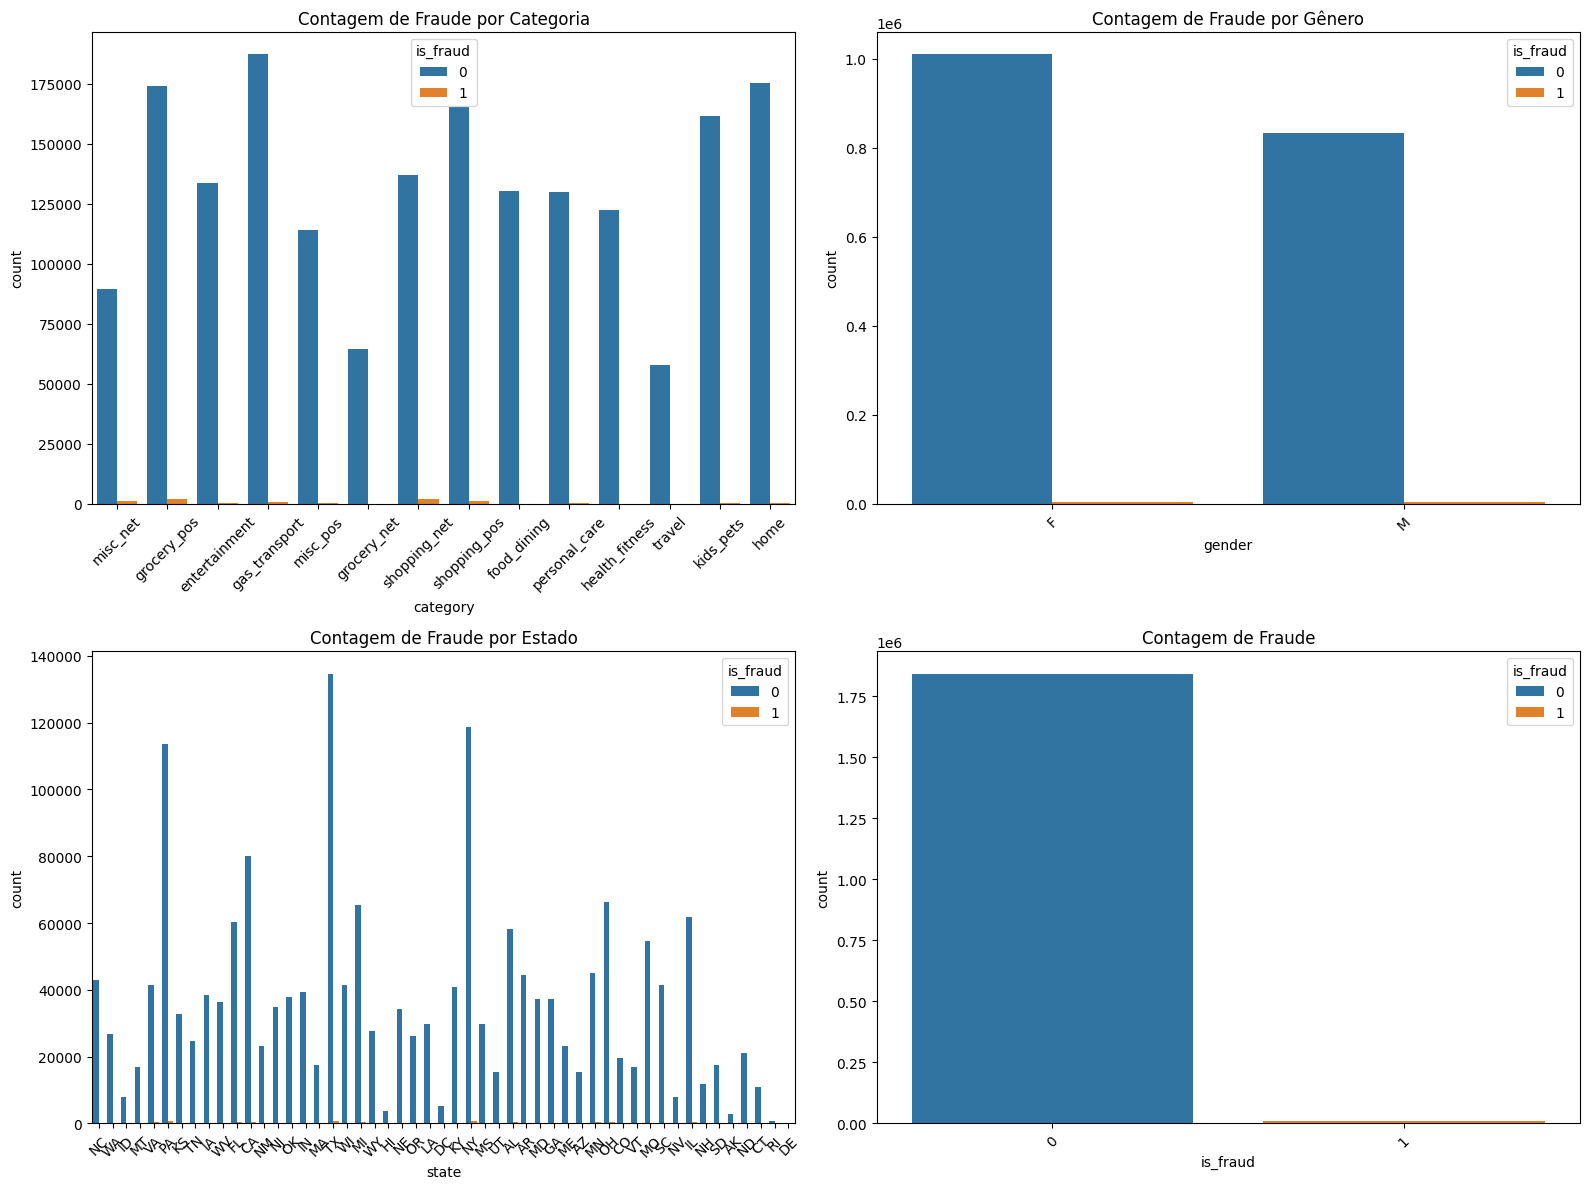

In [14]:
df_anl_cat = df_total[['category','gender','state','is_fraud']] #df so de categoricas elegiveis para analise (APENAS ANALISE)


# Criar a figura com 3 subgráficos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Gráfico de contagem para a variável 'category'
sns.countplot(data=df_anl_cat, x='category', hue='is_fraud', ax=axes[0, 0])
axes[0, 0].set_title('Contagem de Fraude por Categoria')

# 2. Gráfico de contagem para a variável 'gender'
sns.countplot(data=df_anl_cat, x='gender', hue='is_fraud', ax=axes[0, 1])
axes[0, 1].set_title('Contagem de Fraude por Gênero')

# 3. Gráfico de contagem para a variável 'state'
sns.countplot(data=df_anl_cat, x='state', hue='is_fraud', ax=axes[1, 0])
axes[1, 0].set_title('Contagem de Fraude por Estado')

# 3. Gráfico de contagem para a variável 'state'
sns.countplot(data=df_anl_cat, x='is_fraud', hue='is_fraud', ax=axes[1, 1])
axes[1, 1].set_title('Contagem de Fraude')

# Aplicar rotação de 45 graus em todos os rótulos do eixo x
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)  # Rotaciona os rótulos do eixo x para 45 graus

# Ajustar layout
plt.tight_layout()

# Exibir o gráfico
plt.show()



* Verificando a relacao entre as variaveis numericas explicativas (sem variavel alvo)
    * Vemos um agrupamento em valores pequenos para ambas variaveis;
    * embora a variavel alvo esteja na legenda, é meramente para vermos onde se encontrar as observacoes de fraude entre as variaveis, nao e muito conclusivo mas da uma ideia de onde se "agrupam" em termos de valores

In [15]:
# Cria o pairplot
g = sns.pairplot(
    df_anl_num[['amt','city_pop','is_fraud','zip']], 
    hue='is_fraud',
    diag_kind='kde',
    height=2.5,
    aspect=1.2,
    plot_kws={'alpha': 0.3}
)

# Formata os eixos 
for ax in g.axes.flatten():
    # Formatação(sem notação científica automatica)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.tick_params(axis='x', rotation=45) # eixo x em 45 graus

    plt.tight_layout()

plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001DA97C2A200> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

* Verificando a relacao entre as variaveis explicativas categoricas (sem variavel alvo)
    * Aqui verificamos se ha associacao estatistica entre as variveis cetegoricas (sem a alvo) pelo teste de Qui2
    * Verificamos e classificamos em baixa media e alta a forca das associaicoes entre as variaveis categoricas, e plotamos os resultados pelo heatmap de V de Cramer tambem. 

In [ ]:
# df_ de categoricas sem a variavel alvo
df_cat = df_anl_cat[['category', 'gender', 'state']]

def cramers_v(x, y):
    """Calcula o V de Cramer entre duas variáveis categóricas."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Função para categorizar a força do V de Cramer
def categorize_cramers_v(value):
    if value < 0.10:
        return "Baixa Força de"
    elif value < 0.30:
        return "Média Força de"
    else:
        return "Alta Força de"

# Inicializa um DataFrame para armazenar os resultados
results = pd.DataFrame(index=df_cat.columns, columns=df_cat.columns)

for col1 in df_cat.columns:
    for col2 in df_cat.columns:
        if col1 == col2:
            results.loc[col1, col2] = 1.0  # Correlação perfeita com ela mesma
        else:
            table = pd.crosstab(df_cat[col1], df_cat[col2])
            chi2, p, _, _ = chi2_contingency(table)
            v_cramer = cramers_v(df_cat[col1], df_cat[col2])

            # Interpretação do p-valor
            significance = "há evidência de associação" if p < 0.05 else "não há evidência de associação"
            
            # Classificação da força do V de Cramer
            strength = categorize_cramers_v(v_cramer)

            print(f'Teste Qui-Quadrado entre {col1} e {col2}:')
            print(f'Qui²={chi2:.2f}, p-valor={p:.4f} ({"menor" if p < 0.05 else "maior"} que 0.05, {significance}).')
            print(f'V de Cramer={v_cramer:.2f} ({strength} associação)\n')

            results.loc[col1, col2] = v_cramer


# Converte os valores para float
results = results.astype(float)

plt.figure(figsize=(8, 6))
sns.heatmap(results, annot=True, cmap='viridis', fmt='.2f', vmin=0, vmax=1)
plt.title('Heatmap do V de Cramer entre Variáveis Categóricas')
plt.show()




* Aqui evidencia-se o desbalance das classes da variavel alvo, trata-se de um evento raro, conforme ja haviam indicios. 

In [ ]:
# Contar a quantidade de cada classe
fraud_counts = df_total["is_fraud"].value_counts()

# Criar o gráfico de pizza
plt.figure(figsize=(6, 6))
wedges, texts = plt.pie(
    fraud_counts, labels=["Não Fraude", "Fraude"], 
    colors=["green", "red"], startangle=90, wedgeprops={"edgecolor": "black"}
)

# Adicionar os percentuais e contagens formatadas
for i, (text, pct) in enumerate(zip(texts, fraud_counts / fraud_counts.sum() * 100)):
    count_formatted = f"{fraud_counts.iloc[i]:,}".replace(",", ".")
    text.set_text(f"{text.get_text()} ({pct:.2f}%) - {count_formatted}")

# Adicionar título
plt.title("Distribuição da Variável-Alvo (is_fraud)", fontsize=14, fontweight="bold")

# Mostrar o gráfico
plt.show()


* Verificando localizacao das transacoes e dos titulares dos cartoes 
    * Aqui foi dado foco nos maiores ofensores de fraudes: as variaveis de compra presencial "_pos" e online "_net" pois apresentaram grande parte das fraudes 
    * Ha maior concentracao de transacoes do lado da Costa Leste 
    * Existem transacoes no Havai, Canadá e no Alasca, mas sao em pequenos volumes, ainda assim sao estranhas(principalemnte Alasca). 

In [ ]:
# Filtrar apenas transações fraudulentas E que sejam online (_net)
df_fraude_net = df_total[(df_total["is_fraud"] == 1) & (df_total["category"].str.contains("_net", na=False))]

# Criar um DataFrame com as coordenadas SOMENTE de fraudes online
df_mapa = pd.DataFrame({
    "Latitude": list(df_fraude_net["lat"]) + list(df_fraude_net["merch_lat"]),
    "Longitude": list(df_fraude_net["long"]) + list(df_fraude_net["merch_long"]),
    "Tipo": ["Titular"] * len(df_fraude_net) + ["Estabelecimento"] * len(df_fraude_net)
})

# Amostrar 50% para evitar sobrecarga (ajuste conforme volume de dados)
df_mapa_sample = df_mapa.sample(frac=0.5, random_state=42) if len(df_mapa) > 1000 else df_mapa

# Criar o mapa com os pontos das fraudes online
fig = px.scatter_mapbox(df_mapa_sample, lat="Latitude", lon="Longitude",
                        color="Tipo",  
                        mapbox_style="carto-positron",
                        zoom=3, 
                        color_discrete_map={"Titular": "orange", "Estabelecimento": "blue"}  # Define cores personalizadas
                        )

# Ajustar layout com margem superior maior para exibir o título
fig.update_layout(
    width=1700,  
    height=700,  
    margin={"r":0, "t":50, "b":0, "l":0},
    title={
        "text": "AMOSTRA de Distribuição das Transações Fraudulentas ONLINE por Localização do Titular e Estabelecimento",
        "x": 0.5,  # Centraliza o título
        "xanchor": "center",  # Garante alinhamento centralizado
        "yanchor": "top",
        "font": {"size": 20, "family": "Arial Black"}  # Aumenta o tamanho e deixa em negrito
    }
)


fig.show()


In [ ]:
# Filtrar apenas transações fraudulentas E que sejam presenciais (_pos)
df_fraude_net = df_total[(df_total["is_fraud"] == 1) & (df_total["category"].str.contains("_pos", na=False))]

# Criar um DataFrame com as coordenadas SOMENTE de fraudes presenciais
df_mapa = pd.DataFrame({
    "Latitude": list(df_fraude_net["lat"]) + list(df_fraude_net["merch_lat"]),
    "Longitude": list(df_fraude_net["long"]) + list(df_fraude_net["merch_long"]),
    "Tipo": ["Titular"] * len(df_fraude_net) + ["Estabelecimento"] * len(df_fraude_net)
})

# Amostrar 50% para evitar sobrecarga (ajuste conforme volume de dados)
df_mapa_sample = df_mapa.sample(frac=0.5, random_state=42) if len(df_mapa) > 1000 else df_mapa

# Criar o mapa com os pontos das fraudes presenciais, definindo cores específicas
fig = px.scatter_mapbox(df_mapa_sample, lat="Latitude", lon="Longitude",
                        color="Tipo",  
                        mapbox_style="carto-positron",
                        zoom=3,
                        color_discrete_map={"Titular": "orange", "Estabelecimento": "blue"}  # Define cores personalizadas
)

# Ajustar layout
fig.update_layout(
    width=1700,  
    height=700,  
    margin={"r":0, "t":50, "b":0, "l":0},
    title={
        "text": "AMOSTRA de Distribuição das Transações Fraudulentas PRESENCIAIS por Localização do Titular e Estabelecimento",
        "x": 0.5,  
        "xanchor": "center",  
        "yanchor": "top",
        "font": {"size": 20, "family": "Arial Black"}  
    }
)

fig.show()


# 3 Preparação dos Dados: Feature Engineering


* estudar a criacao de uma variavel que identifica a distancia (se e anormal) entre duas transacoes, acho que usar o racional da variavel de contagem de vezes que o cartao foi usado na ultima hora (trans_count_last_hour) 
ex: uma transacao feita presencialemnte seguida de outra presencialmente em locais muito distantes em 1 hora (ou outro periodo se for o caso) podem indicar uma possivel fraude

* criando variavel de distancia em Km entre estabeleciemnto e titular do cartao para compras presencias. 
    * Foi usada a distância entre os pontos pela fórmula de Haversine, pois ela considera a curvatura da Terra e retorna a distância real em km, diferentemente da Euclidiana, que assume um espaço plano (2D) e não converte diretamente em quilômetros.

In [16]:
# Função para remover variáveis desnecessarias
def Limpa_df(df, colunas_para_excluir):
    df = df.drop(columns=colunas_para_excluir, errors='ignore')  # ignora colunas que não existem
    #df = df.dropna()  # remove linhas com valores ausentes
    return df




def mover_target_para_final(df, target):
    """
    Move a variavel alvo para o final do df

    Isso nao interfere em resultados, e para manter o padrao de legibilidade e facilitar a visualizacao da target
    """
    colunas = [col for col in df.columns if col != target] + [target]
    return df[colunas]



In [17]:
# criando variavel de distancia em Km entre estabeleciemnto e titular do cartao para compras presencias (nao faz sentido para compras online que podem e muito provavlemente sera, bem distantes)
#essa variavel permitira entender se a compra presencial foi muito distante do local do titular do cartao, podendo indicar possivel fraude, isso sera estudado


# Definindo as categorias presenciais
categorias_presenciais = [
    "misc_pos", "grocery_pos", "gas_transport", 
    "shopping_pos", "personal_care", "health_fitness"
]


# Função para calcular distância Haversine em KM
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Raio médio da Terra em km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Aplicar linha a linha
# eliminando caso ja tenha 
#if 'distancia_km' in df_total.columns:
#    df_total = df_total.drop(columns='distancia_km')

df_total["distancia_km"] = df_total.apply(
    lambda row: haversine(row["lat"], row["long"], row["merch_lat"], row["merch_long"])
    if row["category"] in categorias_presenciais else np.nan,
    axis=1
)

#trata NAN 
df_total["distancia_km"] = df_total["distancia_km"].fillna(0)


df_total.head(10)





,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,distancia_km
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.01,-82.05,0,0.00
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.16,-118.19,0,30.21
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.18,-112.26,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.15,-112.15,0,0.00
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.23,-112.11,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.03,-112.56,0,95.67
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.42,-79.46,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.67,-78.63,0,77.56
5,2019-01-01 00:04:08,4767265376804500,"fraud_Stroman, Hudson and Erdman",gas_transport,94.63,Jennifer,Conner,F,4655 David Island,Dublin,PA,18917,40.38,-75.20,2158,Transport planner,1961-06-19,189a841a0a8ba03058526bcfe566aab5,1325376248,40.65,-76.15,0,85.92
6,2019-01-01 00:04:42,30074693890476,fraud_Rowe-Vandervort,grocery_net,44.54,Kelsey,Richards,F,889 Sarah Station Suite 624,Holcomb,KS,67851,37.99,-100.99,2691,Arboriculturist,1993-08-16,83ec1cc84142af6e2acf10c44949e720,1325376282,37.16,-100.15,0,0.00
7,2019-01-01 00:05:08,6011360759745864,fraud_Corwin-Collins,gas_transport,71.65,Steven,Williams,M,231 Flores Pass Suite 720,Edinburg,VA,22824,38.84,-78.60,6018,"Designer, multimedia",1947-08-21,6d294ed2cc447d2c71c7171a3d54967c,1325376308,38.95,-78.54,0,12.77
8,2019-01-01 00:05:18,4922710831011201,fraud_Herzog Ltd,misc_pos,4.27,Heather,Chase,F,6888 Hicks Stream Suite 954,Manor,PA,15665,40.34,-79.66,1472,Public affairs consultant,1941-03-07,fc28024ce480f8ef21a32d64c93a29f5,1325376318,40.35,-79.96,0,25.27
9,2019-01-01 00:06:01,2720830304681674,"fraud_Schoen, Kuphal and Nitzsche",grocery_pos,198.39,Melissa,Aguilar,F,21326 Taylor Squares Suite 708,Clarksville,TN,37040,36.52,-87.35,151785,Pathologist,1974-03-28,3b9014ea8fb80bd65de0b1463b00b00e,1325376361,37.18,-87.49,0,74.08


* Testando a distancia entre as variaveis em um mapa 
    * sugiro conferir em https://www.movable-type.co.uk/scripts/latlong.html tambem, para ter cereteza da logica de Haversine implantada (comparar os resultados da variavel de distancia pegando as coord e jogando la)

In [18]:
n_observacao=3 #deve ser observacao presencial as demais nao teram valor para essa variavel
# Selecionar a primeira observação do df_total
obs = df_total[df_total["cc_num"] == df_total["cc_num"].iloc[n_observacao]].iloc[0]

# Extrair coordenadas
lat1, lon1 = obs['lat'], obs['long']
lat2, lon2 = obs['merch_lat'], obs['merch_long']
distancia_km = obs['distancia_km']

# Criar DataFrame com os dois pontos
df_pontos = pd.DataFrame({
    'Nome': ['Titular', 'Estabelecimento'],
    'Latitude': [lat1, lat2],
    'Longitude': [lon1, lon2]
})

# Criar figura
fig = go.Figure()

# Adicionar os dois pontos
fig.add_trace(go.Scattermapbox(
    lat=df_pontos['Latitude'],
    lon=df_pontos['Longitude'],
    mode='markers+text',
    text=df_pontos['Nome'],
    marker=dict(size=12, color=['purple', 'blue']),
    textposition="top center",
    name='Pontos'
))

# Linha entre os pontos
fig.add_trace(go.Scattermapbox(
    lat=[lat1, lat2],
    lon=[lon1, lon2],
    mode='lines',
    line=dict(width=2, color='gray'),
    name='Distância reta'
))

# Ponto médio com rótulo da distância
if pd.notna(distancia_km):
    lat_meio = (lat1 + lat2) / 2
    lon_meio = (lon1 + lon2) / 2
    fig.add_trace(go.Scattermapbox(
        lat=[lat_meio],
        lon=[lon_meio],
        mode='markers+text',
        text=[f'{round(distancia_km, 2)} km'],
        marker=dict(size=1, color='white'),  # marcador minúsculo e invisível
        textfont=dict(size=14, color='black'),
        textposition="top center",
        showlegend=False
    ))

# Layout do mapa
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=3,
    mapbox_center={"lat": (lat1 + lat2) / 2, "lon": (lon1 + lon2) / 2},
    margin={"r":0,"t":0,"l":0,"b":0},
    height=500,
    title=f"Mapa: {obs['cc_num']} | Categoria: {obs['category']}"
)

fig.show()


* Verificando as quantidades por "categoria" (criada so pra analise, nao e uma feature) de distancias, para identificar concentracoes em distancias maiores para transacoes presenciais. 
    * Distancias muito grandes para compras presenciais e um estabelecimento "pode" pontar um padrao de fraudes;
    * Ha maior concentracao em fraudes presenciais de 50 a 100 km de distancia entre endereco do titular e o estabelecimento, e uma distancia aceitavel, pode significar viagens, trabalho ... Nada muito discrepante. 
    * Ha poucas variaveis com km acima de 120, nao parecem ser indcios de padrao de fraude. 

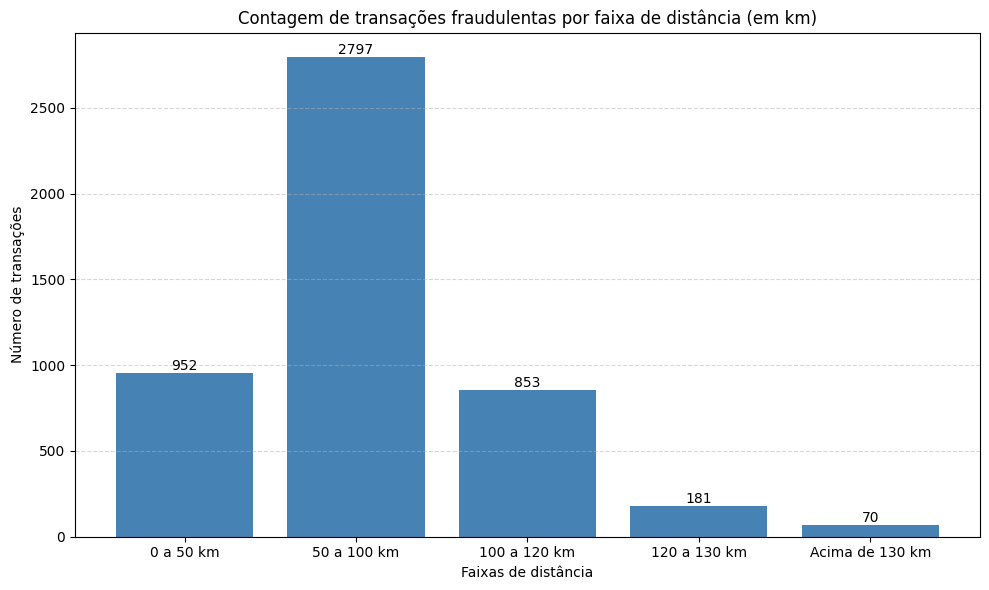

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,distancia_km,faixa_distancia
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.01,-82.05,0,0.00,NaN
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.16,-118.19,0,30.21,0 a 50 km
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.18,-112.26,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.15,-112.15,0,0.00,NaN
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.23,-112.11,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.03,-112.56,0,95.67,50 a 100 km
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.42,-79.46,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.67,-78.63,0,77.56,50 a 100 km


In [19]:
# Criação da variável categórica com base nas faixas de distância
bins = [0, 50, 100, 120, 130, float('inf')]
labels = ['0 a 50 km', '50 a 100 km', '100 a 120 km', '120 a 130 km', 'Acima de 130 km']

df_total['faixa_distancia'] = pd.cut(df_total['distancia_km'], bins=bins, labels=labels, right=True)

# Agora podemos fazer o agrupamento diretamente com essa nova variável
contagens = df_total[df_total['is_fraud'] == 1]['faixa_distancia'].value_counts().reindex(labels)

# Gráfico
plt.figure(figsize=(10, 6))
bars = plt.bar(contagens.index, contagens.values, color='steelblue')

# Adicionando rótulos
for bar, count in zip(bars, contagens.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count),
             ha='center', va='bottom', fontsize=10)

plt.title('Contagem de transações fraudulentas por faixa de distância (em km)')
plt.ylabel('Número de transações')
plt.xlabel('Faixas de distância')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#trata NAN 
#df_total["faixa_distancia"] = df_total["faixa_distancia"].fillna(0)



df_total.head(5)


In [20]:
# Copia a coluna de trans_num para preserva-la comom coluna de dados no df 
df_total["trans_num_copy"] = df_total["trans_num"]

# Define o índice como trans_num 
df_total.set_index("trans_num_copy", inplace=True)


In [21]:
df_total.index.name = None #tira o cabecalho da variavel trans_num da primeira linha do df

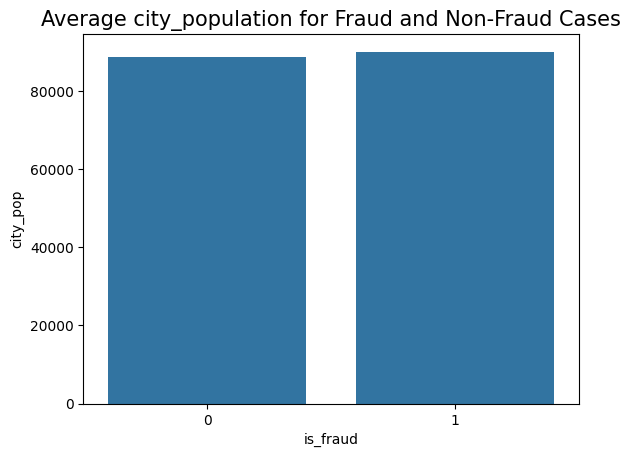

T-test: t-statistic = 0.443, p-value = 0.658, p-value<0.05? False


In [22]:
sns.barplot(data=df_total,x='is_fraud', y='city_pop', ci=None)
plt.title('Average city_population for Fraud and Non-Fraud Cases',fontsize=15)
plt.show()

fraud_population = df_total[df_total['is_fraud'] == 1]['city_pop']
non_fraud_population = df_total[df_total['is_fraud'] == 0]['city_pop']
t_stat, p_value = ttest_ind(fraud_population, non_fraud_population)
print(f'T-test: t-statistic = {round(t_stat,3)}, p-value = {round(p_value,3)}, p-value<0.05? {p_value<0.05}')



In [23]:
#Como aceitamos a hipótese nula(p-val > 0.05), concluímos que não há diferença significativa entre as médias.
#Concluímos também que city_population não nos ajuda no alvo (is_fraud), então o descartaremos.

In [24]:
# Dropando colunas desnecessarias
colunas_excluir = ['unix_time','city_pop','first','last']
df_total = Limpa_df(df_total, colunas_excluir)

#colunas_excluir = ['unix_time', 'zip', 'state', 'city', 'street', 'gender', 'last', 'first','job','merchant']

df_total.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,long,job,dob,trans_num,merch_lat,merch_long,is_fraud,distancia_km,faixa_distancia
0b242abb623afc578575680df30655b9,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,36.01,-82.05,0,0.00,NaN
1f76529f8574734946361c461b024d99,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.89,-118.21,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,49.16,-118.19,0,30.21,0 a 50 km
a1a22d70485983eac12b5b88dad1cf95,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,594 White Dale Suite 530,Malad City,ID,83252,42.18,-112.26,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,43.15,-112.15,0,0.00,NaN
6b849c168bdad6f867558c3793159a81,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.23,-112.11,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,47.03,-112.56,0,95.67,50 a 100 km
a41d7549acf90789359a9aa5346dcb46,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,408 Bradley Rest,Doe Hill,VA,24433,38.42,-79.46,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,38.67,-78.63,0,77.56,50 a 100 km


In [25]:
#clean merchant column
df_total['merchant'] = df_total['merchant'].apply(lambda x : x.replace('fraud_',''))
df_total.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,long,job,dob,trans_num,merch_lat,merch_long,is_fraud,distancia_km,faixa_distancia
0b242abb623afc578575680df30655b9,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,F,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,36.01,-82.05,0,0.00,NaN
1f76529f8574734946361c461b024d99,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.89,-118.21,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,49.16,-118.19,0,30.21,0 a 50 km
a1a22d70485983eac12b5b88dad1cf95,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,M,594 White Dale Suite 530,Malad City,ID,83252,42.18,-112.26,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,43.15,-112.15,0,0.00,NaN
6b849c168bdad6f867558c3793159a81,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.23,-112.11,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,47.03,-112.56,0,95.67,50 a 100 km
a41d7549acf90789359a9aa5346dcb46,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,M,408 Bradley Rest,Doe Hill,VA,24433,38.42,-79.46,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,38.67,-78.63,0,77.56,50 a 100 km


* WOEEncoder() transforma variáveis categóricas em valores numéricos com base na razão entre eventos (ex: fraudes) e não eventos, usando log-odds. Quanto maior o valor de WOE, maior a associação com o evento (fraude); quanto menor, maior a associação com a ausência do evento. Como o WOE já tem interpretação estatística, não deve ser normalizado com StandardScaler, pois isso distorce seu significado.

In [26]:
#We will encode ('city','job','merchant', 'category') preparing for our model using WOE encoder
for col in ['city','job','merchant', 'category']:
    df_total[col] = WOEEncoder().fit_transform(df_total[col],df_total['is_fraud'])

# WOE > 0: The category is more likely associated with (fraud)
# WOE < 0: The category is more likely associated with (non-fraud)


#Convert gender to binary classification
df_total = pd.get_dummies(df_total,columns=['gender'],drop_first=True)
df_total.head(5)


#NAO APLICAR SCALER NESSAS VARAIVEIS COM WOEENCODER()

,trans_date_trans_time,cc_num,merchant,category,amt,street,city,state,zip,lat,long,job,dob,trans_num,merch_lat,merch_long,is_fraud,distancia_km,faixa_distancia,gender_M
0b242abb623afc578575680df30655b9,2019-01-01 00:00:18,2703186189652095,1.01,0.93,4.97,561 Perry Cove,-0.24,NC,28654,36.08,-81.18,-0.40,1988-03-09,0b242abb623afc578575680df30655b9,36.01,-82.05,0,0.00,NaN,False
1f76529f8574734946361c461b024d99,2019-01-01 00:00:44,630423337322,0.68,0.89,107.23,43039 Riley Greens Suite 393,-0.80,WA,99160,48.89,-118.21,-0.69,1978-06-21,1f76529f8574734946361c461b024d99,49.16,-118.19,0,30.21,0 a 50 km,False
a1a22d70485983eac12b5b88dad1cf95,2019-01-01 00:00:51,38859492057661,-0.83,-0.87,220.11,594 White Dale Suite 530,0.86,ID,83252,42.18,-112.26,1.49,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,43.15,-112.15,0,0.00,NaN,True
6b849c168bdad6f867558c3793159a81,2019-01-01 00:01:16,3534093764340240,-0.67,-0.24,45.00,9443 Cynthia Court Apt. 038,1.43,MT,59632,46.23,-112.11,0.10,1967-01-12,6b849c168bdad6f867558c3793159a81,47.03,-112.56,0,95.67,50 a 100 km,True
a41d7549acf90789359a9aa5346dcb46,2019-01-01 00:03:06,375534208663984,-0.40,-0.61,41.96,408 Bradley Rest,-0.09,VA,24433,38.42,-79.46,-0.09,1986-03-28,a41d7549acf90789359a9aa5346dcb46,38.67,-78.63,0,77.56,50 a 100 km,True


* A variável horas_entre_transacoes representa o intervalo de tempo, em horas, entre transações consecutivas de um mesmo cartão de crédito. Ela foi criada para analisar o comportamento temporal das transações, para identificar padrões que possam indicar transações fraudulentas. 


* O teste t indica uma diferença estatisticamente significativa entre o tempo médio entre transações de clientes fraudulentos e não fraudulentos. Com um valor T de 27.27 e um p-valor de 0.00, as transações fraudulentas parecem ter um padrão distinto de tempo em comparação com as não fraudulentas, o que sugere que o tempo entre transações pode ser um fator importante na identificação de comportamentos suspeitos.

* A diferença de média observada sugere que as transações fraudulentas podem ocorrer em intervalos de tempo consideravelmente diferentes — mais curtos, neste caso — em relação às transações não fraudulentas.

* Como o p-valor é menor que 0,05, rejeitamos a hipótese nula. Isso confirma que a média do intervalo em horas entre transações é significativamente diferente entre transações fraudulentas e não fraudulentas.

           T  p-val
T-test 27.27   0.00


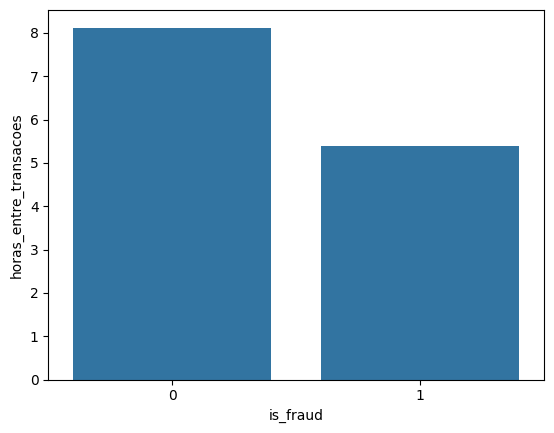

In [27]:
import pingouin

# Converter 'dob' e 'trans_date...' para datetime
df_total["dob"] = pd.to_datetime(df_total["dob"])
df_total["trans_date_trans_time"] = pd.to_datetime(df_total["trans_date_trans_time"])

#We will get the time between transactions for each card
#Time=0 for every first transaction and time will be represented in hours.
df_total.sort_values(['cc_num', 'trans_date_trans_time'],inplace=True)
df_total['horas_entre_transacoes']=((df_total.groupby('cc_num')[['trans_date_trans_time']].diff())/np.timedelta64(1,'h'))


df_total.loc[df_total['horas_entre_transacoes'].isna(),'horas_entre_transacoes'] = 0
df_total['horas_entre_transacoes'] = df_total['horas_entre_transacoes'].astype(int)


# x_0=df.groupby('is_fraud')['horas_entre_transacoes'].mean().values[0]
# x_1=df.groupby('is_fraud')['horas_entre_transacoes'].mean().values[1]
# std_0=df.groupby('is_fraud')['horas_entre_transacoes'].std().values[0]
# std_1=df.groupby('is_fraud')['horas_entre_transacoes'].std().values[1]
# n_0=df.groupby('is_fraud')['horas_entre_transacoes'].count().values[0]
# n_1=df.groupby('is_fraud')['horas_entre_transacoes'].count().values[1]
# numerator = x_0 - x_1
# domin = np.sqrt(std_0**2/n_0 + std_1**2/n_1)
# t_stat=numerator/domin
# p_val = 2*(1-t.cdf(abs(t_stat),df=n_0+n_1-2))
# print(t_stat,p_val)
#----------------------
#The power of pingouin library!
print(pingouin.ttest(df_total[df_total['is_fraud'] == 0]['horas_entre_transacoes'],
              df_total[df_total['is_fraud'] == 1]['horas_entre_transacoes'],
              alternative='two-sided')[['T','p-val']])
sns.barplot(data=df_total,x='is_fraud',y='horas_entre_transacoes',ci=None)
plt.show()

In [28]:

df_total.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,street,city,state,zip,lat,long,job,dob,trans_num,merch_lat,merch_long,is_fraud,distancia_km,faixa_distancia,gender_M,horas_entre_transacoes
98e3dcf98101146a577f85a34e58feec,2019-01-01 12:47:15,60416207185,0.47,0.93,7.27,9886 Anita Drive,-0.19,WY,82514,43.00,-108.90,0.16,1986-02-17,98e3dcf98101146a577f85a34e58feec,43.97,-109.74,0,0.00,NaN,False,0
498120fc45d277f7c88e3dba79c33865,2019-01-02 08:44:57,60416207185,-0.50,-0.24,52.94,9886 Anita Drive,-0.19,WY,82514,43.00,-108.90,0.16,1986-02-17,498120fc45d277f7c88e3dba79c33865,42.02,-109.04,0,110.31,100 a 120 km,False,19
95f514bb993151347c7acdf8505c3d62,2019-01-02 08:47:36,60416207185,-0.13,-0.24,82.08,9886 Anita Drive,-0.19,WY,82514,43.00,-108.90,0.16,1986-02-17,95f514bb993151347c7acdf8505c3d62,42.96,-109.16,0,21.79,0 a 50 km,False,0
4f0c1a14e0aa7eb56a490780ef9268c5,2019-01-02 12:38:14,60416207185,-0.62,-1.02,34.79,9886 Anita Drive,-0.19,WY,82514,43.00,-108.90,0.16,1986-02-17,4f0c1a14e0aa7eb56a490780ef9268c5,42.23,-108.75,0,0.00,NaN,False,3
3b2ebd3af508afba959640893e1e82bc,2019-01-02 13:10:46,60416207185,-1.30,-1.24,27.18,9886 Anita Drive,-0.19,WY,82514,43.00,-108.90,0.16,1986-02-17,3b2ebd3af508afba959640893e1e82bc,43.32,-108.09,0,0.00,NaN,False,0


* A variável age foi criada para representar a idade do titular do cartão no momento de cada transação. Ela é calculada a partir da diferença entre o ano da transação e o ano de nascimento, evitando distorções que poderiam ocorrer ao usar a data atual. Após a criação da variável age, a coluna de data de nascimento (dob) foi removida, pois já não era mais necessária para a análise.

In [29]:
#transformar variaveis com transformacao relevante (inicialmente) no dicionario de dados CONTINUAR

#calculando a idade
#usando a diferenca entre o nascimento e o momento da transacao para evitar distorcoes (usar a data atual criaria uma idade flutuante ao longo do tempo)
df_total["age"] = df_total.apply(lambda linha: linha["trans_date_trans_time"].year - linha["dob"].year, axis=1) #funcao lambda "linha" que aplica a subtracao de datas linha a linha no df_total atraves do apply()

#remove data de nascimento, nao e mais util
df_total.drop(columns=["dob"], inplace=True)

df_total.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,street,city,state,zip,lat,long,job,trans_num,merch_lat,merch_long,is_fraud,distancia_km,faixa_distancia,gender_M,horas_entre_transacoes,age
98e3dcf98101146a577f85a34e58feec,2019-01-01 12:47:15,60416207185,0.47,0.93,7.27,9886 Anita Drive,-0.19,WY,82514,43.00,-108.90,0.16,98e3dcf98101146a577f85a34e58feec,43.97,-109.74,0,0.00,NaN,False,0,33
498120fc45d277f7c88e3dba79c33865,2019-01-02 08:44:57,60416207185,-0.50,-0.24,52.94,9886 Anita Drive,-0.19,WY,82514,43.00,-108.90,0.16,498120fc45d277f7c88e3dba79c33865,42.02,-109.04,0,110.31,100 a 120 km,False,19,33
95f514bb993151347c7acdf8505c3d62,2019-01-02 08:47:36,60416207185,-0.13,-0.24,82.08,9886 Anita Drive,-0.19,WY,82514,43.00,-108.90,0.16,95f514bb993151347c7acdf8505c3d62,42.96,-109.16,0,21.79,0 a 50 km,False,0,33
4f0c1a14e0aa7eb56a490780ef9268c5,2019-01-02 12:38:14,60416207185,-0.62,-1.02,34.79,9886 Anita Drive,-0.19,WY,82514,43.00,-108.90,0.16,4f0c1a14e0aa7eb56a490780ef9268c5,42.23,-108.75,0,0.00,NaN,False,3,33
3b2ebd3af508afba959640893e1e82bc,2019-01-02 13:10:46,60416207185,-1.30,-1.24,27.18,9886 Anita Drive,-0.19,WY,82514,43.00,-108.90,0.16,3b2ebd3af508afba959640893e1e82bc,43.32,-108.09,0,0.00,NaN,False,0,33


* A variável bin foi criada para representar o código do banco da transação, extraído dos primeiros 6 dígitos do número do cartão (cc_num). Essa informação é importante para identificar a instituição financeira associada à transação.

In [30]:
df_total["bin"] = df_total["cc_num"].astype(str).str[:6]
df_total.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,street,city,state,zip,lat,long,job,trans_num,merch_lat,merch_long,is_fraud,distancia_km,faixa_distancia,gender_M,horas_entre_transacoes,age,bin
98e3dcf98101146a577f85a34e58feec,2019-01-01 12:47:15,60416207185,0.47,0.93,7.27,9886 Anita Drive,-0.19,WY,82514,43.00,-108.90,0.16,98e3dcf98101146a577f85a34e58feec,43.97,-109.74,0,0.00,NaN,False,0,33,604162
498120fc45d277f7c88e3dba79c33865,2019-01-02 08:44:57,60416207185,-0.50,-0.24,52.94,9886 Anita Drive,-0.19,WY,82514,43.00,-108.90,0.16,498120fc45d277f7c88e3dba79c33865,42.02,-109.04,0,110.31,100 a 120 km,False,19,33,604162
95f514bb993151347c7acdf8505c3d62,2019-01-02 08:47:36,60416207185,-0.13,-0.24,82.08,9886 Anita Drive,-0.19,WY,82514,43.00,-108.90,0.16,95f514bb993151347c7acdf8505c3d62,42.96,-109.16,0,21.79,0 a 50 km,False,0,33,604162
4f0c1a14e0aa7eb56a490780ef9268c5,2019-01-02 12:38:14,60416207185,-0.62,-1.02,34.79,9886 Anita Drive,-0.19,WY,82514,43.00,-108.90,0.16,4f0c1a14e0aa7eb56a490780ef9268c5,42.23,-108.75,0,0.00,NaN,False,3,33,604162
3b2ebd3af508afba959640893e1e82bc,2019-01-02 13:10:46,60416207185,-1.30,-1.24,27.18,9886 Anita Drive,-0.19,WY,82514,43.00,-108.90,0.16,3b2ebd3af508afba959640893e1e82bc,43.32,-108.09,0,0.00,NaN,False,0,33,604162


* As variáveis relacionadas ao horário da transação foram extraídas para fornecer uma análise mais detalhada do momento da transação. A coluna day_of_week indica o dia da semana em que a transação ocorreu (0 para segunda-feira, 6 para domingo), e a coluna month representa o mês da transação. A coluna time contém o horário completo (hora:minuto:segundo) da transação.

* Além disso, a variável period classifica o horário da transação em períodos do dia, como "Madrugada Início", "Manhã Final", "Tarde Início", entre outros, com base na hora extraída da transação. Essas informações podem ser úteis para analisar padrões de comportamento de transações ao longo do tempo.

In [31]:
# extraindo variaveis do horario da transacao

# Certificando que a coluna 'trans_date_trans_time' está no formato datetime
df_total['trans_date_trans_time'] = pd.to_datetime(df_total['trans_date_trans_time'])

# Extraindo o dia da semana (0=segunda, 1=terça, ..., 6=domingo)
df_total['day_of_week'] = df_total['trans_date_trans_time'].dt.dayofweek

# Extraindo o mês
df_total['month'] = df_total['trans_date_trans_time'].dt.month

# Extraindo o horário completo (hora:minuto:segundo)
df_total['time'] = df_total['trans_date_trans_time'].dt.strftime('%H:%M:%S')


def classify_period(hour):
    if 0 <= hour < 3:
        return 'Madrugada Início'
    elif 3 <= hour < 6:
        return 'Madrugada Final'
    elif 6 <= hour < 9:
        return 'Manhã Início'
    elif 9 <= hour < 12:
        return 'Manhã Final'
    elif 12 <= hour < 15:
        return 'Tarde Início'
    elif 15 <= hour < 18:
        return 'Tarde Final'
    elif 18 <= hour < 21:
        return 'Noite Início'
    elif 21 <= hour < 24:
        return 'Noite Final'


# Extraindo a hora da transação
df_total['hour'] = df_total['trans_date_trans_time'].dt.hour

# Aplicando a função para classificar o período
df_total['period'] = df_total['hour'].apply(classify_period)

df_total.head(5)


,trans_date_trans_time,cc_num,merchant,category,amt,street,city,state,zip,lat,long,job,trans_num,merch_lat,merch_long,is_fraud,distancia_km,faixa_distancia,gender_M,horas_entre_transacoes,age,bin,day_of_week,month,time,hour,period
98e3dcf98101146a577f85a34e58feec,2019-01-01 12:47:15,60416207185,0.47,0.93,7.27,9886 Anita Drive,-0.19,WY,82514,43.00,-108.90,0.16,98e3dcf98101146a577f85a34e58feec,43.97,-109.74,0,0.00,NaN,False,0,33,604162,1,1,12:47:15,12,Tarde Início
498120fc45d277f7c88e3dba79c33865,2019-01-02 08:44:57,60416207185,-0.50,-0.24,52.94,9886 Anita Drive,-0.19,WY,82514,43.00,-108.90,0.16,498120fc45d277f7c88e3dba79c33865,42.02,-109.04,0,110.31,100 a 120 km,False,19,33,604162,2,1,08:44:57,8,Manhã Início
95f514bb993151347c7acdf8505c3d62,2019-01-02 08:47:36,60416207185,-0.13,-0.24,82.08,9886 Anita Drive,-0.19,WY,82514,43.00,-108.90,0.16,95f514bb993151347c7acdf8505c3d62,42.96,-109.16,0,21.79,0 a 50 km,False,0,33,604162,2,1,08:47:36,8,Manhã Início
4f0c1a14e0aa7eb56a490780ef9268c5,2019-01-02 12:38:14,60416207185,-0.62,-1.02,34.79,9886 Anita Drive,-0.19,WY,82514,43.00,-108.90,0.16,4f0c1a14e0aa7eb56a490780ef9268c5,42.23,-108.75,0,0.00,NaN,False,3,33,604162,2,1,12:38:14,12,Tarde Início
3b2ebd3af508afba959640893e1e82bc,2019-01-02 13:10:46,60416207185,-1.30,-1.24,27.18,9886 Anita Drive,-0.19,WY,82514,43.00,-108.90,0.16,3b2ebd3af508afba959640893e1e82bc,43.32,-108.09,0,0.00,NaN,False,0,33,604162,2,1,13:10:46,13,Tarde Início


A variável "count_tran_ult_jan_temp" foi criada para contar o número de transações realizadas nos últimos 15 segundos antes de cada transação, com o objetivo de identificar comportamentos suspeitos e padrões de fraudes, como transações seguidas rapidamente. O cálculo considera cada transação e verifica o número de transações anteriores realizadas, para cada cartao, dentro desse intervalo de 15 segundos. Isso pode ajudar a detectar transações fraudulentas que ocorrem em um curto período de tempo.

Os testes indicam uma diferença estatística significativa no número de transações realizadas nos últimos 15 segundos entre transações fraudulentas e não fraudulentas. Com um valor T de -5.55 e um p-valor de 0.00, observamos que as transações fraudulentas tendem a ocorrer com um número menor de transações consecutivas dentro desse intervalo curto, em comparação com as transações não fraudulentas. Isso sugere que o comportamento de transações em intervalos breves pode ser um indicativo de fraude, sendo uma característica distintiva entre os dois grupos.

Como o p-valor é menor que 0,05, rejeitamos a hipótese nula. Isso confirma que a contagem de transações nos últimos 15 segundos é significativamente diferente entre transações fraudulentas e não fraudulentas.

           T  p-val
T-test -5.55   0.00


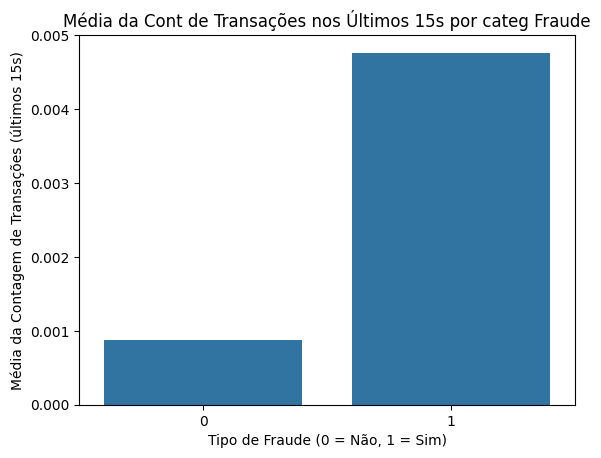

,index,trans_date_trans_time,cc_num,merchant,category,amt,street,city,state,zip,lat,long,job,merch_lat,merch_long,is_fraud,distancia_km,faixa_distancia,gender_M,horas_entre_transacoes,age,bin,day_of_week,month,time,hour,period,count_tran_ult_jan_temp
trans_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0b242abb623afc578575680df30655b9,0b242abb623afc578575680df30655b9,2019-01-01 00:00:18,2703186189652095,1.01,0.93,4.97,561 Perry Cove,-0.24,NC,28654,36.08,-81.18,-0.40,36.01,-82.05,0,0.00,NaN,False,0,31,270318,1,1,00:00:18,0,Madrugada Início,0
1f76529f8574734946361c461b024d99,1f76529f8574734946361c461b024d99,2019-01-01 00:00:44,630423337322,0.68,0.89,107.23,43039 Riley Greens Suite 393,-0.80,WA,99160,48.89,-118.21,-0.69,49.16,-118.19,0,30.21,0 a 50 km,False,0,41,630423,1,1,00:00:44,0,Madrugada Início,0
a1a22d70485983eac12b5b88dad1cf95,a1a22d70485983eac12b5b88dad1cf95,2019-01-01 00:00:51,38859492057661,-0.83,-0.87,220.11,594 White Dale Suite 530,0.86,ID,83252,42.18,-112.26,1.49,43.15,-112.15,0,0.00,NaN,True,0,57,388594,1,1,00:00:51,0,Madrugada Início,0
6b849c168bdad6f867558c3793159a81,6b849c168bdad6f867558c3793159a81,2019-01-01 00:01:16,3534093764340240,-0.67,-0.24,45.00,9443 Cynthia Court Apt. 038,1.43,MT,59632,46.23,-112.11,0.10,47.03,-112.56,0,95.67,50 a 100 km,True,0,52,353409,1,1,00:01:16,0,Madrugada Início,0
a41d7549acf90789359a9aa5346dcb46,a41d7549acf90789359a9aa5346dcb46,2019-01-01 00:03:06,375534208663984,-0.40,-0.61,41.96,408 Bradley Rest,-0.09,VA,24433,38.42,-79.46,-0.09,38.67,-78.63,0,77.56,50 a 100 km,True,0,33,375534,1,1,00:03:06,0,Madrugada Início,0


In [32]:
# Converter para datetime e ordenar
df_total['trans_date_trans_time'] = pd.to_datetime(df_total['trans_date_trans_time'])
df_total = df_total.sort_values(by=['trans_date_trans_time', 'cc_num'])

# Resetar o índice temporariamente para permitir o uso com numpy (evita erro com string como índice)
df_total_reset = df_total.reset_index()  # trans_num vira coluna

# Criar array para armazenar a contagem
trans_count_list = np.zeros(len(df_total_reset), dtype=int)

# Aplicar a contagem eficiente usando searchsorted()
for card, group in df_total_reset.groupby('cc_num'):
    timestamps = group['trans_date_trans_time'].values
    idx = np.searchsorted(timestamps, timestamps - np.timedelta64(15, 's'), side='left')
    trans_count_list[group.index] = np.arange(len(group)) - idx

# Atribuir os valores ao DataFrame
df_total_reset['count_tran_ult_jan_temp'] = trans_count_list

# Restaurar o índice original 'trans_num'
df_total = df_total_reset.set_index('trans_num')



#validando logica (comparar as horas entre as transacoes e se a quantidade bate)
#df_filtro = df_total[df_total['cc_num'] == 	4613314721966]
#df_filtro = df_filtro[df_filtro['is_fraud'] == 1	]

#df_filtro = df_filtro.sort_values(by='trans_date_trans_time', ascending=False)  # Ordenar do maior para o menor

#df_filtro.head(1000)



import pingouin
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
'''
# Considerando que a variável 'count_tran_ult_jan_temp' foi criada para contar as transações nos últimos 15 segundos
# Usando o código estatístico para comparar as médias entre as categorias de is_fraud (0 = Não, 1 = Sim)

# Calculando as médias e desvio padrão para as duas categorias de is_fraud
x_0 = df_total[df_total['is_fraud'] == 0]['count_tran_ult_jan_temp'].mean()  # Média para 'Não Fraude'
x_1 = df_total[df_total['is_fraud'] == 1]['count_tran_ult_jan_temp'].mean()  # Média para 'Fraude'

std_0 = df_total[df_total['is_fraud'] == 0]['count_tran_ult_jan_temp'].std()  # Desvio padrão para 'Não Fraude'
std_1 = df_total[df_total['is_fraud'] == 1]['count_tran_ult_jan_temp'].std()  # Desvio padrão para 'Fraude'

n_0 = df_total[df_total['is_fraud'] == 0]['count_tran_ult_jan_temp'].count()  # Contagem para 'Não Fraude'
n_1 = df_total[df_total['is_fraud'] == 1]['count_tran_ult_jan_temp'].count()  # Contagem para 'Fraude'

# Cálculo do valor t e p-valor
numerator = x_0 - x_1
denominator = np.sqrt(std_0**2 / n_0 + std_1**2 / n_1)
t_stat = numerator / denominator

# Graus de liberdade
df = n_0 + n_1 - 2
p_val = 2 * (1 - stats.t.cdf(abs(t_stat), df))

# Exibindo t_stat e p_val
print(f"t-statistic: {t_stat}, p-value: {p_val}")

'''

#-----------------------------
# Usando a biblioteca Pingouin para realizar o teste t
ttest_result = pingouin.ttest(
    df_total[df_total['is_fraud'] == 0]['count_tran_ult_jan_temp'],
    df_total[df_total['is_fraud'] == 1]['count_tran_ult_jan_temp'],
    alternative='two-sided'
)

# Exibindo resultado do teste
print(ttest_result[['T', 'p-val']])

# Gráfico de barras para visualizar a contagem de transações por tipo de fraude
sns.barplot(data=df_total, x='is_fraud', y='count_tran_ult_jan_temp', ci=None)
plt.title('Média da Cont de Transações nos Últimos 15s por categ Fraude')
plt.xlabel('Tipo de Fraude (0 = Não, 1 = Sim)')
plt.ylabel('Média da Contagem de Transações (últimos 15s)')
plt.show()

df_total.head(5)





* Variável de Frequência de Uso do Cartão foi criada com base na quantidade de vezes que cada cartão foi utilizado ao longo de todo o período da amostra. O objetivo dessa variável é medir a frequência de uso do cartão e verificar se cartões com menor frequência de uso (como cartões novos ou pouco utilizados) estão mais associados a transações fraudulentas.

* A análise mostra que as fraudes ocorrem com maior frequência em cartões com baixo número de utilizações, indicando um padrão mais comum em cartões novos ou pouco usados. Já as transações genuínas apresentam uma distribuição mais próxima da normalidade em relação à frequência de uso dos cartões.

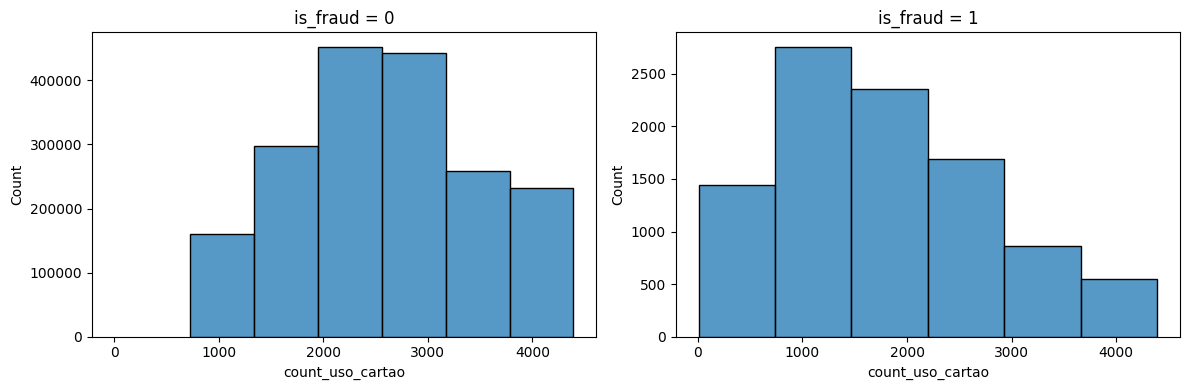

Categorias únicas: [4 6 1 2 3 5]


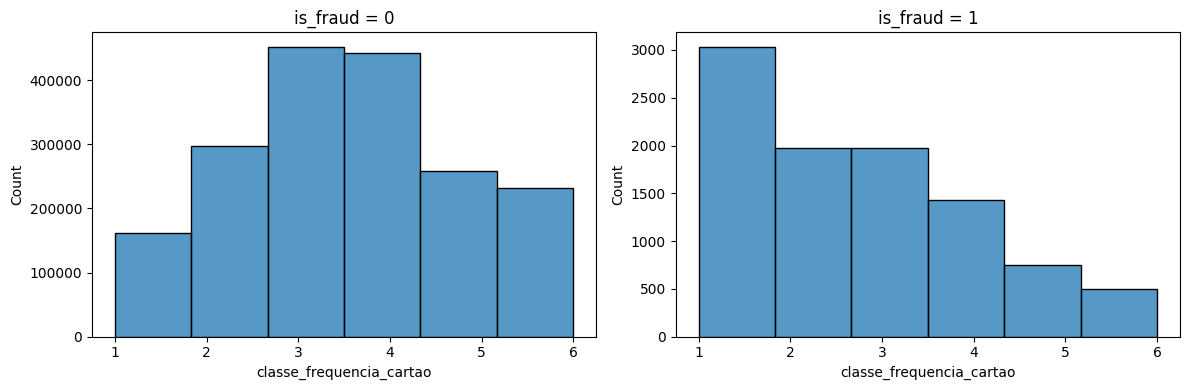

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Função para exibir histogramas lado a lado
def hist_show(col):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    for i in [0, 1]:
        sns.histplot(df_total[df_total["is_fraud"] == i][col], bins=6, ax=axs[i])
        axs[i].set_title(f'is_fraud = {i}')
    plt.tight_layout()
    plt.show()

# 2. Contar quantas vezes cada cartão aparece na base
df_qtd_uso_cartoes = df_total.groupby('cc_num').size().reset_index(name='count_uso_cartao')

# 3. Juntar essa informação de volta ao DataFrame original
df_total = df_total.merge(df_qtd_uso_cartoes, on='cc_num', how='left')

# 4. Mostrar histograma da contagem original
hist_show('count_uso_cartao')

# 5. Função para classificar o uso do cartão em faixas
def class_det(x):
    for idx, val in enumerate(range(800, 5000, 800)):
        if x < val:
            return idx + 1
    return len(range(800, 5000, 800)) + 1  # Classe extra se acima de 5000

# 6. Criar variável categórica
df_total['classe_frequencia_cartao'] = df_total['count_uso_cartao'].apply(class_det)

# 7. Verificar as classes únicas
print("Categorias únicas:", df_total['classe_frequencia_cartao'].unique())

# 8. Exibir histograma da variável categorizada
hist_show('classe_frequencia_cartao')



# Define o índice novamente (foi desconfigurado nos processos anteriores)
df_total.set_index("index", inplace=True)

df_total.index.name = None #tira o cabecalho da variavel da primeira linha do df


#Aplica def de reorganizar colunas 
df_total = mover_target_para_final(df_total, 'is_fraud')

# Transformação de Horário em Variáveis Cíclicas (Seno e Cosseno)

A variável time, que representa o horário da transação, possui natureza cíclica, ou seja, após 23:59 o ciclo recomeça em 00:00. Modelos de Machine Learning não entendem esse padrão circular por padrão, e tratam 23h e 0h como distantes, quando na verdade são muito próximas.

Para capturar essa ciclicidade corretamente, transformamos a hora em duas novas variáveis usando funções trigonométricas:

time_sin = sin(2π * hora / 24)

time_cos = cos(2π * hora / 24)

Essas variáveis projetam o horário em um círculo unitário, permitindo que o modelo entenda a transição natural entre horários e aprenda padrões temporais com mais precisão.

Essa técnica é especialmente útil em modelos lineares, onde relações cíclicas não são captadas automaticamente.

In [34]:

# Converter a coluna 'time' de string para datetime.time
df_total['time'] = pd.to_datetime(df_total['time'], format='%H:%M:%S').dt.time

# Extrair a hora, minuto e segundo como número decimal de hora
df_total['hora_decimal'] = df_total['time'].apply(lambda x: x.hour + x.minute/60 + x.second/3600)

# Codificação cíclica: seno e cosseno da hora do dia
df_total['time_sin'] = np.sin(2 * np.pi * df_total['hora_decimal'] / 24)
df_total['time_cos'] = np.cos(2 * np.pi * df_total['hora_decimal'] / 24)



#dropando variavel 'time' apos transformaca, caso ela seja necessaia para calcular o tempo entre trnasacoes (se essa variavel for viabilizada, esta em analise se faz sentido) 
#basta comentar essa parte do codigo que ela se mantem 

# Dropando colunas desnecessarias
colunas_excluir = ['time']
df_total = Limpa_df(df_total, colunas_excluir)


#visualizando nova feature
pd.set_option('display.max_rows', None)
df_total.head(10)

,trans_date_trans_time,cc_num,merchant,category,amt,street,city,state,zip,lat,long,job,merch_lat,merch_long,distancia_km,faixa_distancia,gender_M,horas_entre_transacoes,age,bin,day_of_week,month,hour,period,count_tran_ult_jan_temp,count_uso_cartao,classe_frequencia_cartao,is_fraud,hora_decimal,time_sin,time_cos
0b242abb623afc578575680df30655b9,2019-01-01 00:00:18,2703186189652095,1.01,0.93,4.97,561 Perry Cove,-0.24,NC,28654,36.08,-81.18,-0.40,36.01,-82.05,0.00,NaN,False,0,31,270318,1,1,0,Madrugada Início,0,2927,4,0,0.01,0.00,1.00
1f76529f8574734946361c461b024d99,2019-01-01 00:00:44,630423337322,0.68,0.89,107.23,43039 Riley Greens Suite 393,-0.80,WA,99160,48.89,-118.21,-0.69,49.16,-118.19,30.21,0 a 50 km,False,0,41,630423,1,1,0,Madrugada Início,0,4362,6,0,0.01,0.00,1.00
a1a22d70485983eac12b5b88dad1cf95,2019-01-01 00:00:51,38859492057661,-0.83,-0.87,220.11,594 White Dale Suite 530,0.86,ID,83252,42.18,-112.26,1.49,43.15,-112.15,0.00,NaN,True,0,57,388594,1,1,0,Madrugada Início,0,735,1,0,0.01,0.00,1.00
6b849c168bdad6f867558c3793159a81,2019-01-01 00:01:16,3534093764340240,-0.67,-0.24,45.00,9443 Cynthia Court Apt. 038,1.43,MT,59632,46.23,-112.11,0.10,47.03,-112.56,95.67,50 a 100 km,True,0,52,353409,1,1,0,Madrugada Início,0,743,1,0,0.02,0.01,1.00
a41d7549acf90789359a9aa5346dcb46,2019-01-01 00:03:06,375534208663984,-0.40,-0.61,41.96,408 Bradley Rest,-0.09,VA,24433,38.42,-79.46,-0.09,38.67,-78.63,77.56,50 a 100 km,True,0,33,375534,1,1,0,Madrugada Início,0,2922,4,0,0.05,0.01,1.00
189a841a0a8ba03058526bcfe566aab5,2019-01-01 00:04:08,4767265376804500,-0.22,-0.24,94.63,4655 David Island,0.74,PA,18917,40.38,-75.20,0.49,40.65,-76.15,85.92,50 a 100 km,False,0,58,476726,1,1,0,Madrugada Início,0,736,1,0,0.07,0.02,1.00
83ec1cc84142af6e2acf10c44949e720,2019-01-01 00:04:42,30074693890476,-0.54,-0.66,44.54,889 Sarah Station Suite 624,0.11,KS,67851,37.99,-100.99,0.05,37.16,-100.15,0.00,NaN,False,0,26,300746,1,1,0,Madrugada Início,0,2933,4,0,0.08,0.02,1.00
6d294ed2cc447d2c71c7171a3d54967c,2019-01-01 00:05:08,6011360759745864,-0.23,-0.24,71.65,231 Flores Pass Suite 720,0.05,VA,22824,38.84,-78.60,0.80,38.95,-78.54,12.77,0 a 50 km,True,0,72,601136,1,1,0,Madrugada Início,0,1464,2,0,0.09,0.02,1.00
fc28024ce480f8ef21a32d64c93a29f5,2019-01-01 00:05:18,4922710831011201,-0.88,-0.61,4.27,6888 Hicks Stream Suite 954,0.53,PA,15665,40.34,-79.66,0.37,40.35,-79.96,25.27,0 a 50 km,False,0,78,492271,1,1,0,Madrugada Início,0,1470,2,0,0.09,0.02,1.00
3b9014ea8fb80bd65de0b1463b00b00e,2019-01-01 00:06:01,2720830304681674,0.79,0.89,198.39,21326 Taylor Squares Suite 708,0.27,TN,37040,36.52,-87.35,0.36,37.18,-87.49,74.08,50 a 100 km,False,0,45,272083,1,1,0,Madrugada Início,0,1467,2,0,0.10,0.03,1.00


* verificando os tipos das variaveis e a contagem de categorias das categoricas 
    * das 3 categoricas e possivel notar que a vartaivel bin que corresponde ao codigo do suposto banco de cada transacao, tem muitas categorias (muitos bancos) isso torna inviavel one hot encoder
    * Entao na celula seguinte, foi verificado dos bancos mais ofensores em percentual de fraudes por transacao, para encontrar algum padrao 
    * Dado isso, será aplicada uma transformação de Target Encoding (neste caso, Mean Encoding), que substitui cada categoria de bin pela média do target (proporção média de fraude) dentro daquela categoria. 
        * Para evitar overfitting e vazamento de dados, a codificação será aplicada separadamente dentro de cada fold durante a validação cruzada e, posteriormente, no conjunto de teste de forma independente. 
        * Além disso, será utilizado o parâmetro smoothing, que atua como uma forma de regularização. O smoothing realiza um balanceamento entre a média do target por categoria e a média global do target, dando mais peso à média global em categorias com poucas observações. Isso ajuda a suavizar os valores atribuídos a categorias raras e reduz o risco de superestimar seu efeito, tornando o modelo mais robusto.

In [35]:

# VERIFICANDO OS TIPOS PARA POSSIVEL TRANSFORMACAO 
print(df_total.dtypes)

print('')
# Selecionar colunas do tipo object
object_cols = df_total.select_dtypes(include='object').columns

# Contar categorias únicas em cada uma
for col in object_cols:
    print(f"{col}: {df_total[col].nunique()} categorias únicas")



trans_date_trans_time       datetime64[ns]
cc_num                               int64
merchant                           float64
category                           float64
amt                                float64
street                              object
city                               float64
state                               object
zip                                  int64
lat                                float64
long                               float64
job                                float64
merch_lat                          float64
merch_long                         float64
distancia_km                       float64
faixa_distancia                   category
gender_M                              bool
horas_entre_transacoes               int64
age                                  int64
bin                                 object
day_of_week                          int32
month                                int32
hour                                 int32
period     

In [36]:
# Agrupamento por bin com os indicadores
resumo_bin = (
    df_total
    .groupby('bin')
    .agg(
        proporcao_fraude=('is_fraud', 'mean'),
        contagem_fraude=('is_fraud', 'sum'),
        total_transacoes=('is_fraud', 'count')
    )
    .reset_index()
    .sort_values(by='proporcao_fraude', ascending=False)
)

# Auemntar para uns 100 para ver a quebra dos bancos mais ofensores em percentual
resumo_bin.head(10) 


,bin,proporcao_fraude,contagem_fraude,total_transacoes
27,180098,1.00,12,12
4,180020,1.00,12,12
26,180097,1.00,7,7
7,180038,1.00,10,10
960,676179,1.00,11,11
259,352804,1.00,11,11
603,441767,1.00,11,11
299,354733,1.00,11,11
283,354041,1.00,8,8
922,651777,1.00,11,11


In [37]:
# Dropando colunas desnecessarias
#hour sai porque ja foi criada variaveis ciclicas com  Sen e Cos 
colunas_excluir = ['lat', 'long', 'merch_lat', 'merch_long','cc_num','hour']
df_total = Limpa_df(df_total, colunas_excluir)
df_total.head()

,trans_date_trans_time,merchant,category,amt,street,city,state,zip,job,distancia_km,faixa_distancia,gender_M,horas_entre_transacoes,age,bin,day_of_week,month,period,count_tran_ult_jan_temp,count_uso_cartao,classe_frequencia_cartao,is_fraud,hora_decimal,time_sin,time_cos
0b242abb623afc578575680df30655b9,2019-01-01 00:00:18,1.01,0.93,4.97,561 Perry Cove,-0.24,NC,28654,-0.40,0.00,NaN,False,0,31,270318,1,1,Madrugada Início,0,2927,4,0,0.01,0.00,1.00
1f76529f8574734946361c461b024d99,2019-01-01 00:00:44,0.68,0.89,107.23,43039 Riley Greens Suite 393,-0.80,WA,99160,-0.69,30.21,0 a 50 km,False,0,41,630423,1,1,Madrugada Início,0,4362,6,0,0.01,0.00,1.00
a1a22d70485983eac12b5b88dad1cf95,2019-01-01 00:00:51,-0.83,-0.87,220.11,594 White Dale Suite 530,0.86,ID,83252,1.49,0.00,NaN,True,0,57,388594,1,1,Madrugada Início,0,735,1,0,0.01,0.00,1.00
6b849c168bdad6f867558c3793159a81,2019-01-01 00:01:16,-0.67,-0.24,45.00,9443 Cynthia Court Apt. 038,1.43,MT,59632,0.10,95.67,50 a 100 km,True,0,52,353409,1,1,Madrugada Início,0,743,1,0,0.02,0.01,1.00
a41d7549acf90789359a9aa5346dcb46,2019-01-01 00:03:06,-0.40,-0.61,41.96,408 Bradley Rest,-0.09,VA,24433,-0.09,77.56,50 a 100 km,True,0,33,375534,1,1,Madrugada Início,0,2922,4,0,0.05,0.01,1.00


# Aplicar a selecao de fatures por importancia antes do modelo (CONTINUAR)

In [38]:
#################################################

# Modelagem (separar um pouco essa fase, aqui tem separacao de treino e teste, optuna, aplicao final... separa para nao ficar pesada a leitura e correcoes, tipo modularizar mesmo)

* estudar a criacao de uma variavel que identifica a distancia (se e anormal) entre duas transacoes, acho que usar o racional da variavel de contagem de vezes que o cartao foi usado na ultima hora (trans_count_last_hour) 
ex: uma transacao feita presencialemnte seguida de outra presencialmente em locais muito distantes em 1 hora (ou outro periodo se for o caso) podem indicar uma possivel fraude

* Definindo funcoes transformadoras nas variaveis que serao usadas para feature importance, analise de correlacoes e fornecidas finalmente para o modelo 

In [39]:
# ====================
#  1. funcoes transformadoras 
# ====================

# ====================
#  Target Encoding
# ====================
def apply_target_encoding(train, val_or_test, col, target, smoothing=15):
    global_mean = train[target].mean()
    stats = train.groupby(col)[target].agg(['mean', 'count'])
    smooth = (stats['mean'] * stats['count'] + global_mean * smoothing) / (stats['count'] + smoothing)
    encoded_col = val_or_test[col].map(smooth).fillna(global_mean)
    return encoded_col

# ====================
#  # One-Hot Encoding para colunas categóricas
# ====================

def fit_transform_ohe(train_df, val_df, col):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    train_encoded = ohe.fit_transform(train_df[[col]])
    val_encoded = ohe.transform(val_df[[col]])

    train_ohe = pd.DataFrame(train_encoded, columns=[f"{col}_{cat}" for cat in ohe.categories_[0]], index=train_df.index)
    val_ohe = pd.DataFrame(val_encoded, columns=[f"{col}_{cat}" for cat in ohe.categories_[0]], index=val_df.index)

    return train_ohe, val_ohe, ohe


* Dividindo em treino e teste 

In [40]:
#teste usando as posicoes originais dos dados de treino e teste (aqui e pra testar se ha vies de selecao nas bases originais, se o resultado for excelente entao sim teve)
# ====================
# 2. Split em treino e teste
# ====================


# Passo 1: Pegar os trans_num originais
trans_train_ids = df_orig_train['trans_num'].unique()
trans_test_ids = df_orig_test['trans_num'].unique()

# Passo 2: Separar X e y do df_total
X = df_total.drop('is_fraud', axis=1)
y = df_total['is_fraud']

# Passo 3: Usar o índice (que é o trans_num em df_total) para separar
X_train = X.loc[X.index.isin(trans_train_ids)].copy()
X_test = X.loc[X.index.isin(trans_test_ids)].copy()

y_train = y.loc[y.index.isin(trans_train_ids)].copy()
y_test = y.loc[y.index.isin(trans_test_ids)].copy()

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)
print("Total shape:", X.shape, y.shape)

print("Checagem duplicidade entre conjuntos:", set(X_train.index) & set(X_test.index))  # Deve ser vazio


# Dropa as variáveis indesejadas em treino e teste
cols_to_drop = ['trans_date_trans_time', 'cc_num']
X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
X_test = X_test.drop(columns=cols_to_drop, errors='ignore')
X  = X.drop(columns=cols_to_drop, errors='ignore')

# Junta X_train e y_train para uso no Optuna
df_train = X_train.copy()
df_train['is_fraud'] = y_train

target = 'is_fraud'



Train shape: (1296675, 24) (1296675,)
Test shape: (555719, 24) (555719,)
Total shape: (1852394, 24) (1852394,)
Checagem duplicidade entre conjuntos: set()


In [41]:
X_train.head()

,merchant,category,amt,street,city,state,zip,job,distancia_km,faixa_distancia,gender_M,horas_entre_transacoes,age,bin,day_of_week,month,period,count_tran_ult_jan_temp,count_uso_cartao,classe_frequencia_cartao,hora_decimal,time_sin,time_cos
0b242abb623afc578575680df30655b9,1.01,0.93,4.97,561 Perry Cove,-0.24,NC,28654,-0.40,0.00,NaN,False,0,31,270318,1,1,Madrugada Início,0,2927,4,0.01,0.00,1.00
1f76529f8574734946361c461b024d99,0.68,0.89,107.23,43039 Riley Greens Suite 393,-0.80,WA,99160,-0.69,30.21,0 a 50 km,False,0,41,630423,1,1,Madrugada Início,0,4362,6,0.01,0.00,1.00
a1a22d70485983eac12b5b88dad1cf95,-0.83,-0.87,220.11,594 White Dale Suite 530,0.86,ID,83252,1.49,0.00,NaN,True,0,57,388594,1,1,Madrugada Início,0,735,1,0.01,0.00,1.00
6b849c168bdad6f867558c3793159a81,-0.67,-0.24,45.00,9443 Cynthia Court Apt. 038,1.43,MT,59632,0.10,95.67,50 a 100 km,True,0,52,353409,1,1,Madrugada Início,0,743,1,0.02,0.01,1.00
a41d7549acf90789359a9aa5346dcb46,-0.40,-0.61,41.96,408 Bradley Rest,-0.09,VA,24433,-0.09,77.56,50 a 100 km,True,0,33,375534,1,1,Madrugada Início,0,2922,4,0.05,0.01,1.00


# ====================
# 2. Split em treino e teste
# ====================
X = df_total.drop('is_fraud', axis=1)
y = df_total['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Dropa as variáveis indesejadas em treino e teste
cols_to_drop = ['trans_date_trans_time', 'cc_num']
X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
X_test = X_test.drop(columns=cols_to_drop, errors='ignore')
X  = X.drop(columns=cols_to_drop, errors='ignore')

# Junta X_train e y_train para uso no Optuna
df_train = X_train.copy()
df_train['is_fraud'] = y_train

target = 'is_fraud'


* Analisando correlacoes 
    * a funcao aqui aplica as mesmas transformacoes que sao aplicadas no treino e no teste, mas com uma funcao separada para deixar as usadas no modelo somente para o modelo 
    * e feita uam copia do df_treino para preservar o df_treino do modelo. 

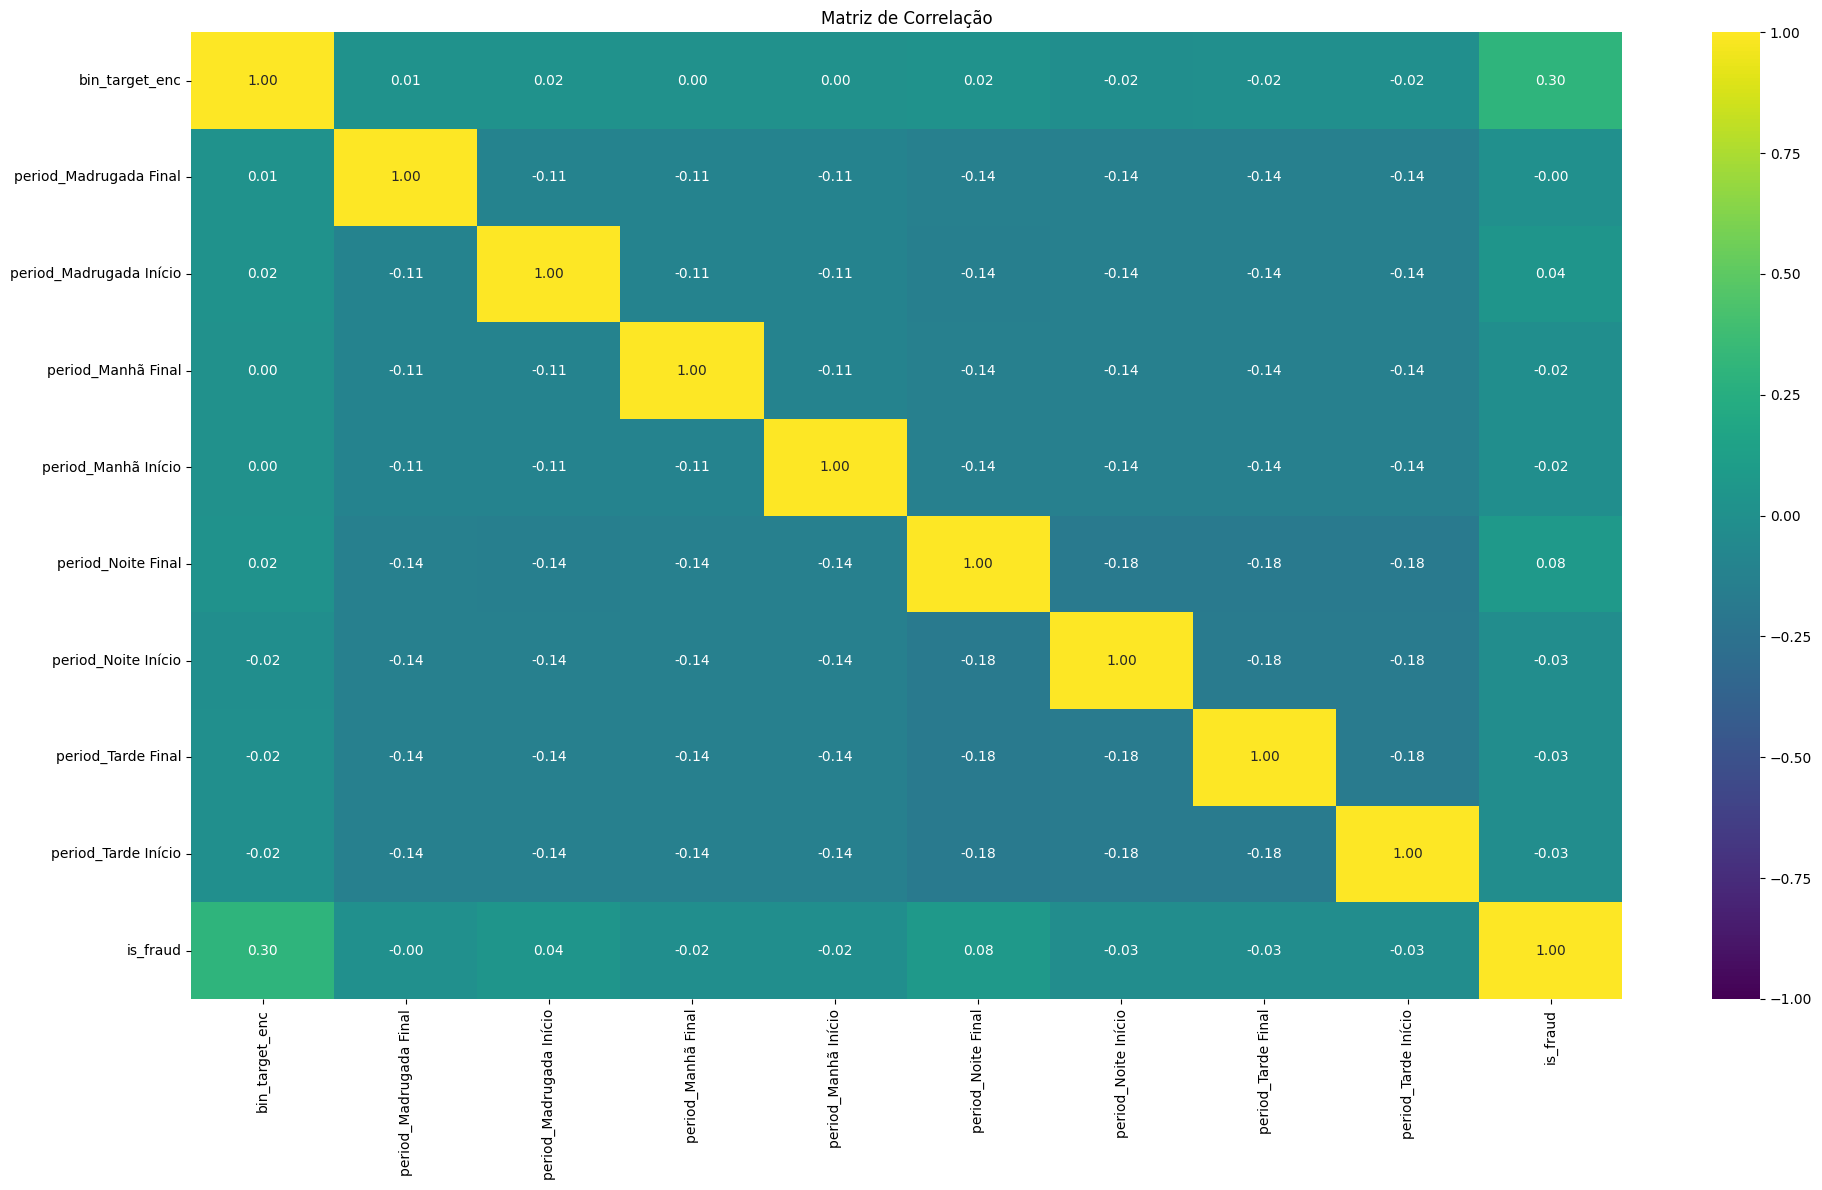

In [42]:
def prepare_df_train_temp(df_train, target):
    # Cria uma cópia para preservar o original
    df_train_temp = df_train.copy()

    # ====== Target Encoding ======
    df_train_temp['bin_target_enc'] = apply_target_encoding(df_train, df_train_temp, 'bin', target)

    # ====== OneHot Encoding ======
    #_, ohe_cat_df, ohe_cat = fit_transform_ohe(df_train, df_train_temp, 'category')
    _, ohe_period_df, ohe_period = fit_transform_ohe(df_train, df_train_temp, 'period')

    # ====== Junta todas as features ======
    #X_temp = pd.concat([df_train_temp[['bin_target_enc']], ohe_cat_df, ohe_period_df], axis=1)
    X_temp = pd.concat([df_train_temp[['bin_target_enc']], ohe_period_df], axis=1)

    # ====== Scaling ======
    scaler = StandardScaler()
    X_temp_scaled = scaler.fit_transform(X_temp)

    # Retorna como DataFrame para análise de correlação
    X_temp_scaled_df = pd.DataFrame(X_temp_scaled, columns=X_temp.columns, index=df_train_temp.index)
    X_temp_scaled_df[target] = df_train_temp[target]  # anexa target para facilitar análise

    return X_temp_scaled_df




#chamando def 
df_train_temp = prepare_df_train_temp(df_train, target)


# Suprimir todos os warnings
warnings.filterwarnings("ignore")

# Criar a figura com 1 subgráfico (apenas o gráfico de correlação)
fig, axes = plt.subplots(1, 1, figsize=(20, 12))

# Matriz de correlação
sns.heatmap(df_train_temp.corr(), annot=True, cmap="viridis", fmt=".2f", ax=axes, vmin=-1, vmax=1)
axes.set_title('Matriz de Correlação')

# Ajustar o layout
plt.tight_layout()
plt.show()



# Importancias das variaveis com Mutual Information

In [43]:
df_train.head(10)

,merchant,category,amt,street,city,state,zip,job,distancia_km,faixa_distancia,gender_M,horas_entre_transacoes,age,bin,day_of_week,month,period,count_tran_ult_jan_temp,count_uso_cartao,classe_frequencia_cartao,hora_decimal,time_sin,time_cos,is_fraud
0b242abb623afc578575680df30655b9,1.01,0.93,4.97,561 Perry Cove,-0.24,NC,28654,-0.40,0.00,NaN,False,0,31,270318,1,1,Madrugada Início,0,2927,4,0.01,0.00,1.00,0
1f76529f8574734946361c461b024d99,0.68,0.89,107.23,43039 Riley Greens Suite 393,-0.80,WA,99160,-0.69,30.21,0 a 50 km,False,0,41,630423,1,1,Madrugada Início,0,4362,6,0.01,0.00,1.00,0
a1a22d70485983eac12b5b88dad1cf95,-0.83,-0.87,220.11,594 White Dale Suite 530,0.86,ID,83252,1.49,0.00,NaN,True,0,57,388594,1,1,Madrugada Início,0,735,1,0.01,0.00,1.00,0
6b849c168bdad6f867558c3793159a81,-0.67,-0.24,45.00,9443 Cynthia Court Apt. 038,1.43,MT,59632,0.10,95.67,50 a 100 km,True,0,52,353409,1,1,Madrugada Início,0,743,1,0.02,0.01,1.00,0
a41d7549acf90789359a9aa5346dcb46,-0.40,-0.61,41.96,408 Bradley Rest,-0.09,VA,24433,-0.09,77.56,50 a 100 km,True,0,33,375534,1,1,Madrugada Início,0,2922,4,0.05,0.01,1.00,0
189a841a0a8ba03058526bcfe566aab5,-0.22,-0.24,94.63,4655 David Island,0.74,PA,18917,0.49,85.92,50 a 100 km,False,0,58,476726,1,1,Madrugada Início,0,736,1,0.07,0.02,1.00,0
83ec1cc84142af6e2acf10c44949e720,-0.54,-0.66,44.54,889 Sarah Station Suite 624,0.11,KS,67851,0.05,0.00,NaN,False,0,26,300746,1,1,Madrugada Início,0,2933,4,0.08,0.02,1.00,0
6d294ed2cc447d2c71c7171a3d54967c,-0.23,-0.24,71.65,231 Flores Pass Suite 720,0.05,VA,22824,0.80,12.77,0 a 50 km,True,0,72,601136,1,1,Madrugada Início,0,1464,2,0.09,0.02,1.00,0
fc28024ce480f8ef21a32d64c93a29f5,-0.88,-0.61,4.27,6888 Hicks Stream Suite 954,0.53,PA,15665,0.37,25.27,0 a 50 km,False,0,78,492271,1,1,Madrugada Início,0,1470,2,0.09,0.02,1.00,0
3b9014ea8fb80bd65de0b1463b00b00e,0.79,0.89,198.39,21326 Taylor Squares Suite 708,0.27,TN,37040,0.36,74.08,50 a 100 km,False,0,45,272083,1,1,Madrugada Início,0,1467,2,0.10,0.03,1.00,0


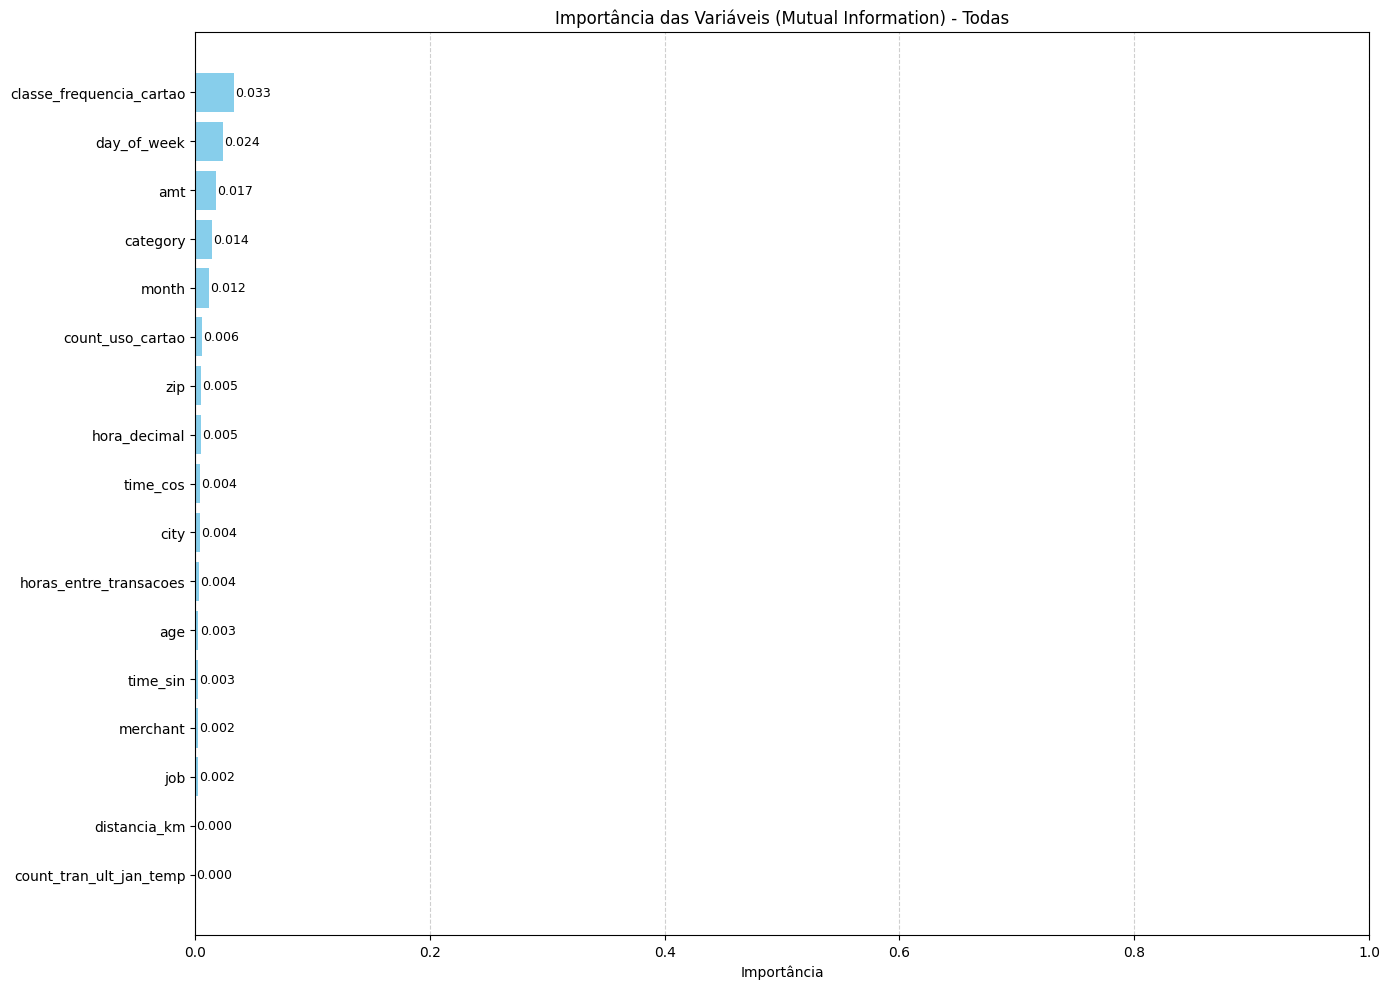

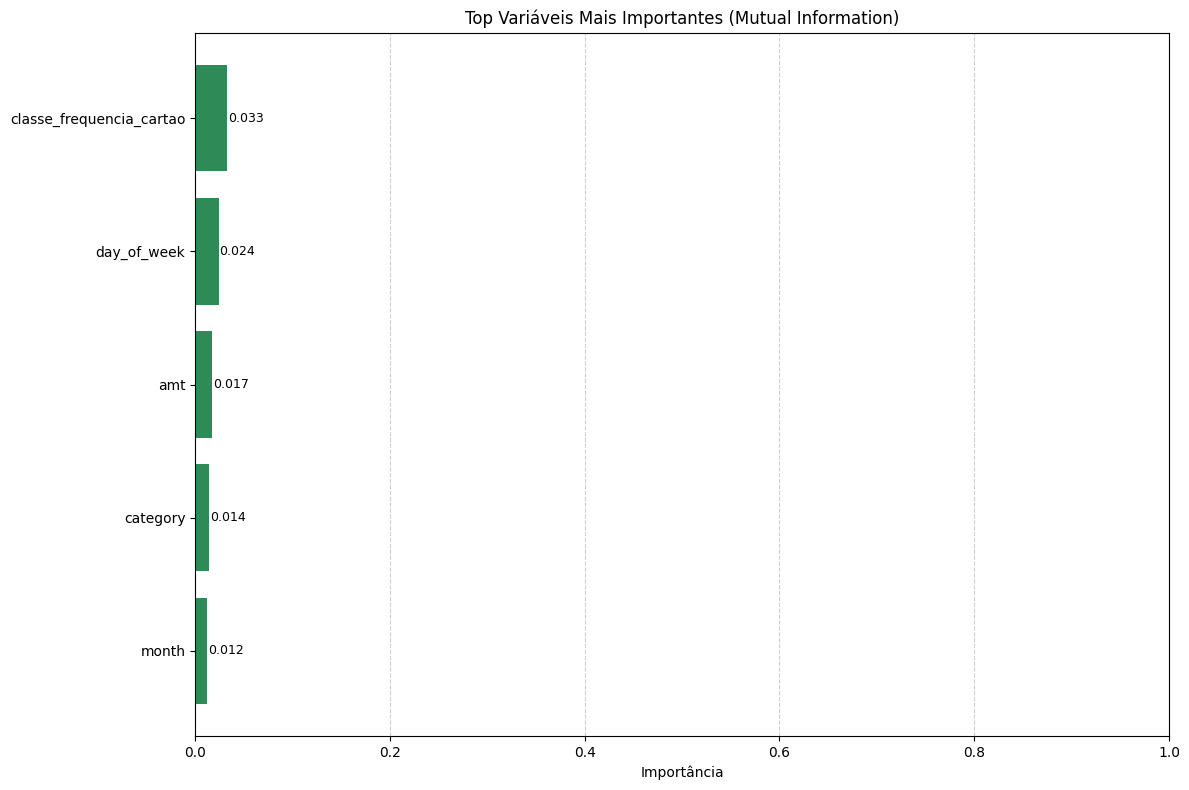

In [44]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Cópia da base original
df_temp = df_train.copy()

# Define as variáveis obrigatórias que sempre ficam
keep_vars = ['bin', 'period', target]

# Cria X e y
X = df_temp.drop(columns=[target, 'bin', 'period'], errors='ignore')
y = df_temp[target]

# Filtra apenas variáveis numéricas
X = X.select_dtypes(include=[np.number])

# Calcula mutual information
mi = mutual_info_classif(X, y, n_neighbors=5, random_state=42)
mi_importances = pd.Series(mi, index=X.columns, name="MutualInformation")

# Seleciona as top variáveis
top = mi_importances.sort_values(ascending=False).head(5).index.tolist()

# Atualiza df_train com top + variáveis obrigatórias
df_train = df_temp[top + keep_vars]

# 📊 Gráfico com todas as variáveis numéricas
plt.figure(figsize=(14, 10))
mi_sorted = mi_importances.sort_values(ascending=True)
bars = plt.barh(mi_sorted.index, mi_sorted.values, color='skyblue')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, f'{width:.3f}',
             va='center', fontsize=9)

plt.title("Importância das Variáveis (Mutual Information) - Todas")
plt.xlabel("Importância")
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 📊 Gráfico com apenas as top variáveis
plt.figure(figsize=(12, 8))
top_sorted = mi_importances[top].sort_values(ascending=True)
bars_top = plt.barh(top_sorted.index, top_sorted.values, color='seagreen')

for bar in bars_top:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, f'{width:.3f}',
             va='center', fontsize=9)

plt.title("Top Variáveis Mais Importantes (Mutual Information)")
plt.xlabel("Importância")
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [45]:
df_train.head(10)

,classe_frequencia_cartao,day_of_week,amt,category,month,bin,period,is_fraud
0b242abb623afc578575680df30655b9,4,1,4.97,0.93,1,270318,Madrugada Início,0
1f76529f8574734946361c461b024d99,6,1,107.23,0.89,1,630423,Madrugada Início,0
a1a22d70485983eac12b5b88dad1cf95,1,1,220.11,-0.87,1,388594,Madrugada Início,0
6b849c168bdad6f867558c3793159a81,1,1,45.00,-0.24,1,353409,Madrugada Início,0
a41d7549acf90789359a9aa5346dcb46,4,1,41.96,-0.61,1,375534,Madrugada Início,0
189a841a0a8ba03058526bcfe566aab5,1,1,94.63,-0.24,1,476726,Madrugada Início,0
83ec1cc84142af6e2acf10c44949e720,4,1,44.54,-0.66,1,300746,Madrugada Início,0
6d294ed2cc447d2c71c7171a3d54967c,2,1,71.65,-0.24,1,601136,Madrugada Início,0
fc28024ce480f8ef21a32d64c93a29f5,2,1,4.27,-0.61,1,492271,Madrugada Início,0
3b9014ea8fb80bd65de0b1463b00b00e,2,1,198.39,0.89,1,272083,Madrugada Início,0


# Outliers 

* AQUI SE ANALISOU OS OUTLIERS PARA TRATAMENTOS POSTERIOES, DENTRO DOS FOLDS, NO TREINAMENTO FINAL, E SEMPRE OBSERVANDO O CUIDADO PARA VAZAMENTO DE DADOS ENTRE TREINO E TESTE. 



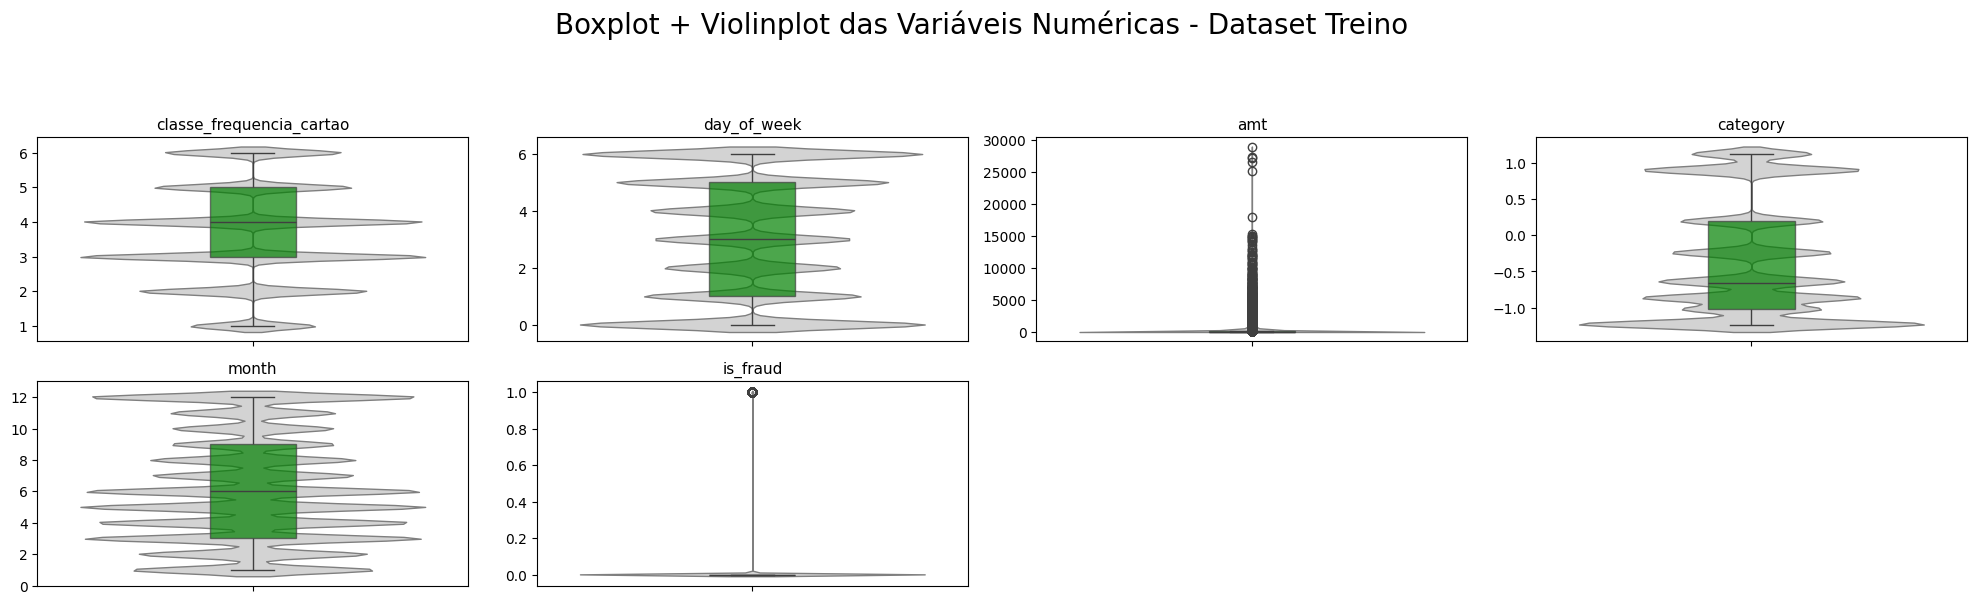

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# lista das variáveis numéricas que você quer visualizar
variaveis = df_train.select_dtypes(include='number').columns.tolist()

# tamanho da figura
plt.figure(figsize=(20, 16))

# loop de criação de subplots com boxplot + violinplot
for i, var in enumerate(variaveis):
    plt.subplot(6, 4, i + 1)  # define a grade de 6 linhas x 4 colunas (ajuste conforme o número de variáveis)
    
    # violinplot com largura menor para não sobrepor tanto
    sns.violinplot(y=df_train[var], inner=None, color='lightgray', linewidth=1)
    
    # boxplot por cima
    sns.boxplot(y=df_train[var],
                boxprops=dict(facecolor='green', alpha=0.7),
                width=0.2)
    
    plt.title(f'{var}', fontsize=11)
    plt.ylabel('')

# título geral
plt.suptitle('Boxplot + Violinplot das Variáveis Numéricas - Dataset Treino', fontsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



# Estudo com Optuna: Melhores hiperparametros

In [47]:
df_train.head(5)

,classe_frequencia_cartao,day_of_week,amt,category,month,bin,period,is_fraud
0b242abb623afc578575680df30655b9,4,1,4.97,0.93,1,270318,Madrugada Início,0
1f76529f8574734946361c461b024d99,6,1,107.23,0.89,1,630423,Madrugada Início,0
a1a22d70485983eac12b5b88dad1cf95,1,1,220.11,-0.87,1,388594,Madrugada Início,0
6b849c168bdad6f867558c3793159a81,1,1,45.00,-0.24,1,353409,Madrugada Início,0
a41d7549acf90789359a9aa5346dcb46,4,1,41.96,-0.61,1,375534,Madrugada Início,0


In [48]:
X_train.head(5)

,merchant,category,amt,street,city,state,zip,job,distancia_km,faixa_distancia,gender_M,horas_entre_transacoes,age,bin,day_of_week,month,period,count_tran_ult_jan_temp,count_uso_cartao,classe_frequencia_cartao,hora_decimal,time_sin,time_cos
0b242abb623afc578575680df30655b9,1.01,0.93,4.97,561 Perry Cove,-0.24,NC,28654,-0.40,0.00,NaN,False,0,31,270318,1,1,Madrugada Início,0,2927,4,0.01,0.00,1.00
1f76529f8574734946361c461b024d99,0.68,0.89,107.23,43039 Riley Greens Suite 393,-0.80,WA,99160,-0.69,30.21,0 a 50 km,False,0,41,630423,1,1,Madrugada Início,0,4362,6,0.01,0.00,1.00
a1a22d70485983eac12b5b88dad1cf95,-0.83,-0.87,220.11,594 White Dale Suite 530,0.86,ID,83252,1.49,0.00,NaN,True,0,57,388594,1,1,Madrugada Início,0,735,1,0.01,0.00,1.00
6b849c168bdad6f867558c3793159a81,-0.67,-0.24,45.00,9443 Cynthia Court Apt. 038,1.43,MT,59632,0.10,95.67,50 a 100 km,True,0,52,353409,1,1,Madrugada Início,0,743,1,0.02,0.01,1.00
a41d7549acf90789359a9aa5346dcb46,-0.40,-0.61,41.96,408 Bradley Rest,-0.09,VA,24433,-0.09,77.56,50 a 100 km,True,0,33,375534,1,1,Madrugada Início,0,2922,4,0.05,0.01,1.00


In [49]:
print("qtd de variaveis e observacoes usados no treino:",df_train.shape)

qtd de variaveis e observacoes usados no treino: (1296675, 8)


In [50]:
# Mantendo apenas as colunas presentes em df_train
# isso porque as tratativas de mutual importance foram feitos na copia do df_train e isso ocorreu depois da separacao de treino e teste, entao e a unica transformcao que acabou nao pegando no X_trian e X_test

colunas_validas = df_train.columns.intersection(X_train.columns)

# Filtrando X_train e X_test
X_train = X_train[colunas_validas]
X_test = X_test[colunas_validas]



📊 Analisando a variável: classe_frequencia_cartao
--------------------------------------------------
Estatística do teste (D’Agostino): 130543.6600
p-valor: 0.0000
❌ Pode não seguir uma distribuição normal.
Estatística do teste Anderson-Darling: 28631.9178
Valores Críticos: [0.576 0.656 0.787 0.918 1.092]
Níveis de significância: [15.  10.   5.   2.5  1. ]
❌ A distribuição não é normal.
Assimetria (Skew): 0.0443
Curtose (Kurtosis): -0.8347

📊 Analisando a variável: day_of_week
--------------------------------------------------
Estatística do teste (D’Agostino): 9333101.6330
p-valor: 0.0000
❌ Pode não seguir uma distribuição normal.
Estatística do teste Anderson-Darling: 46969.4490
Valores Críticos: [0.576 0.656 0.787 0.918 1.092]
Níveis de significância: [15.  10.   5.   2.5  1. ]
❌ A distribuição não é normal.
Assimetria (Skew): -0.0785
Curtose (Kurtosis): -1.4450

📊 Analisando a variável: amt
--------------------------------------------------
Estatística do teste (D’Agostino): 38557

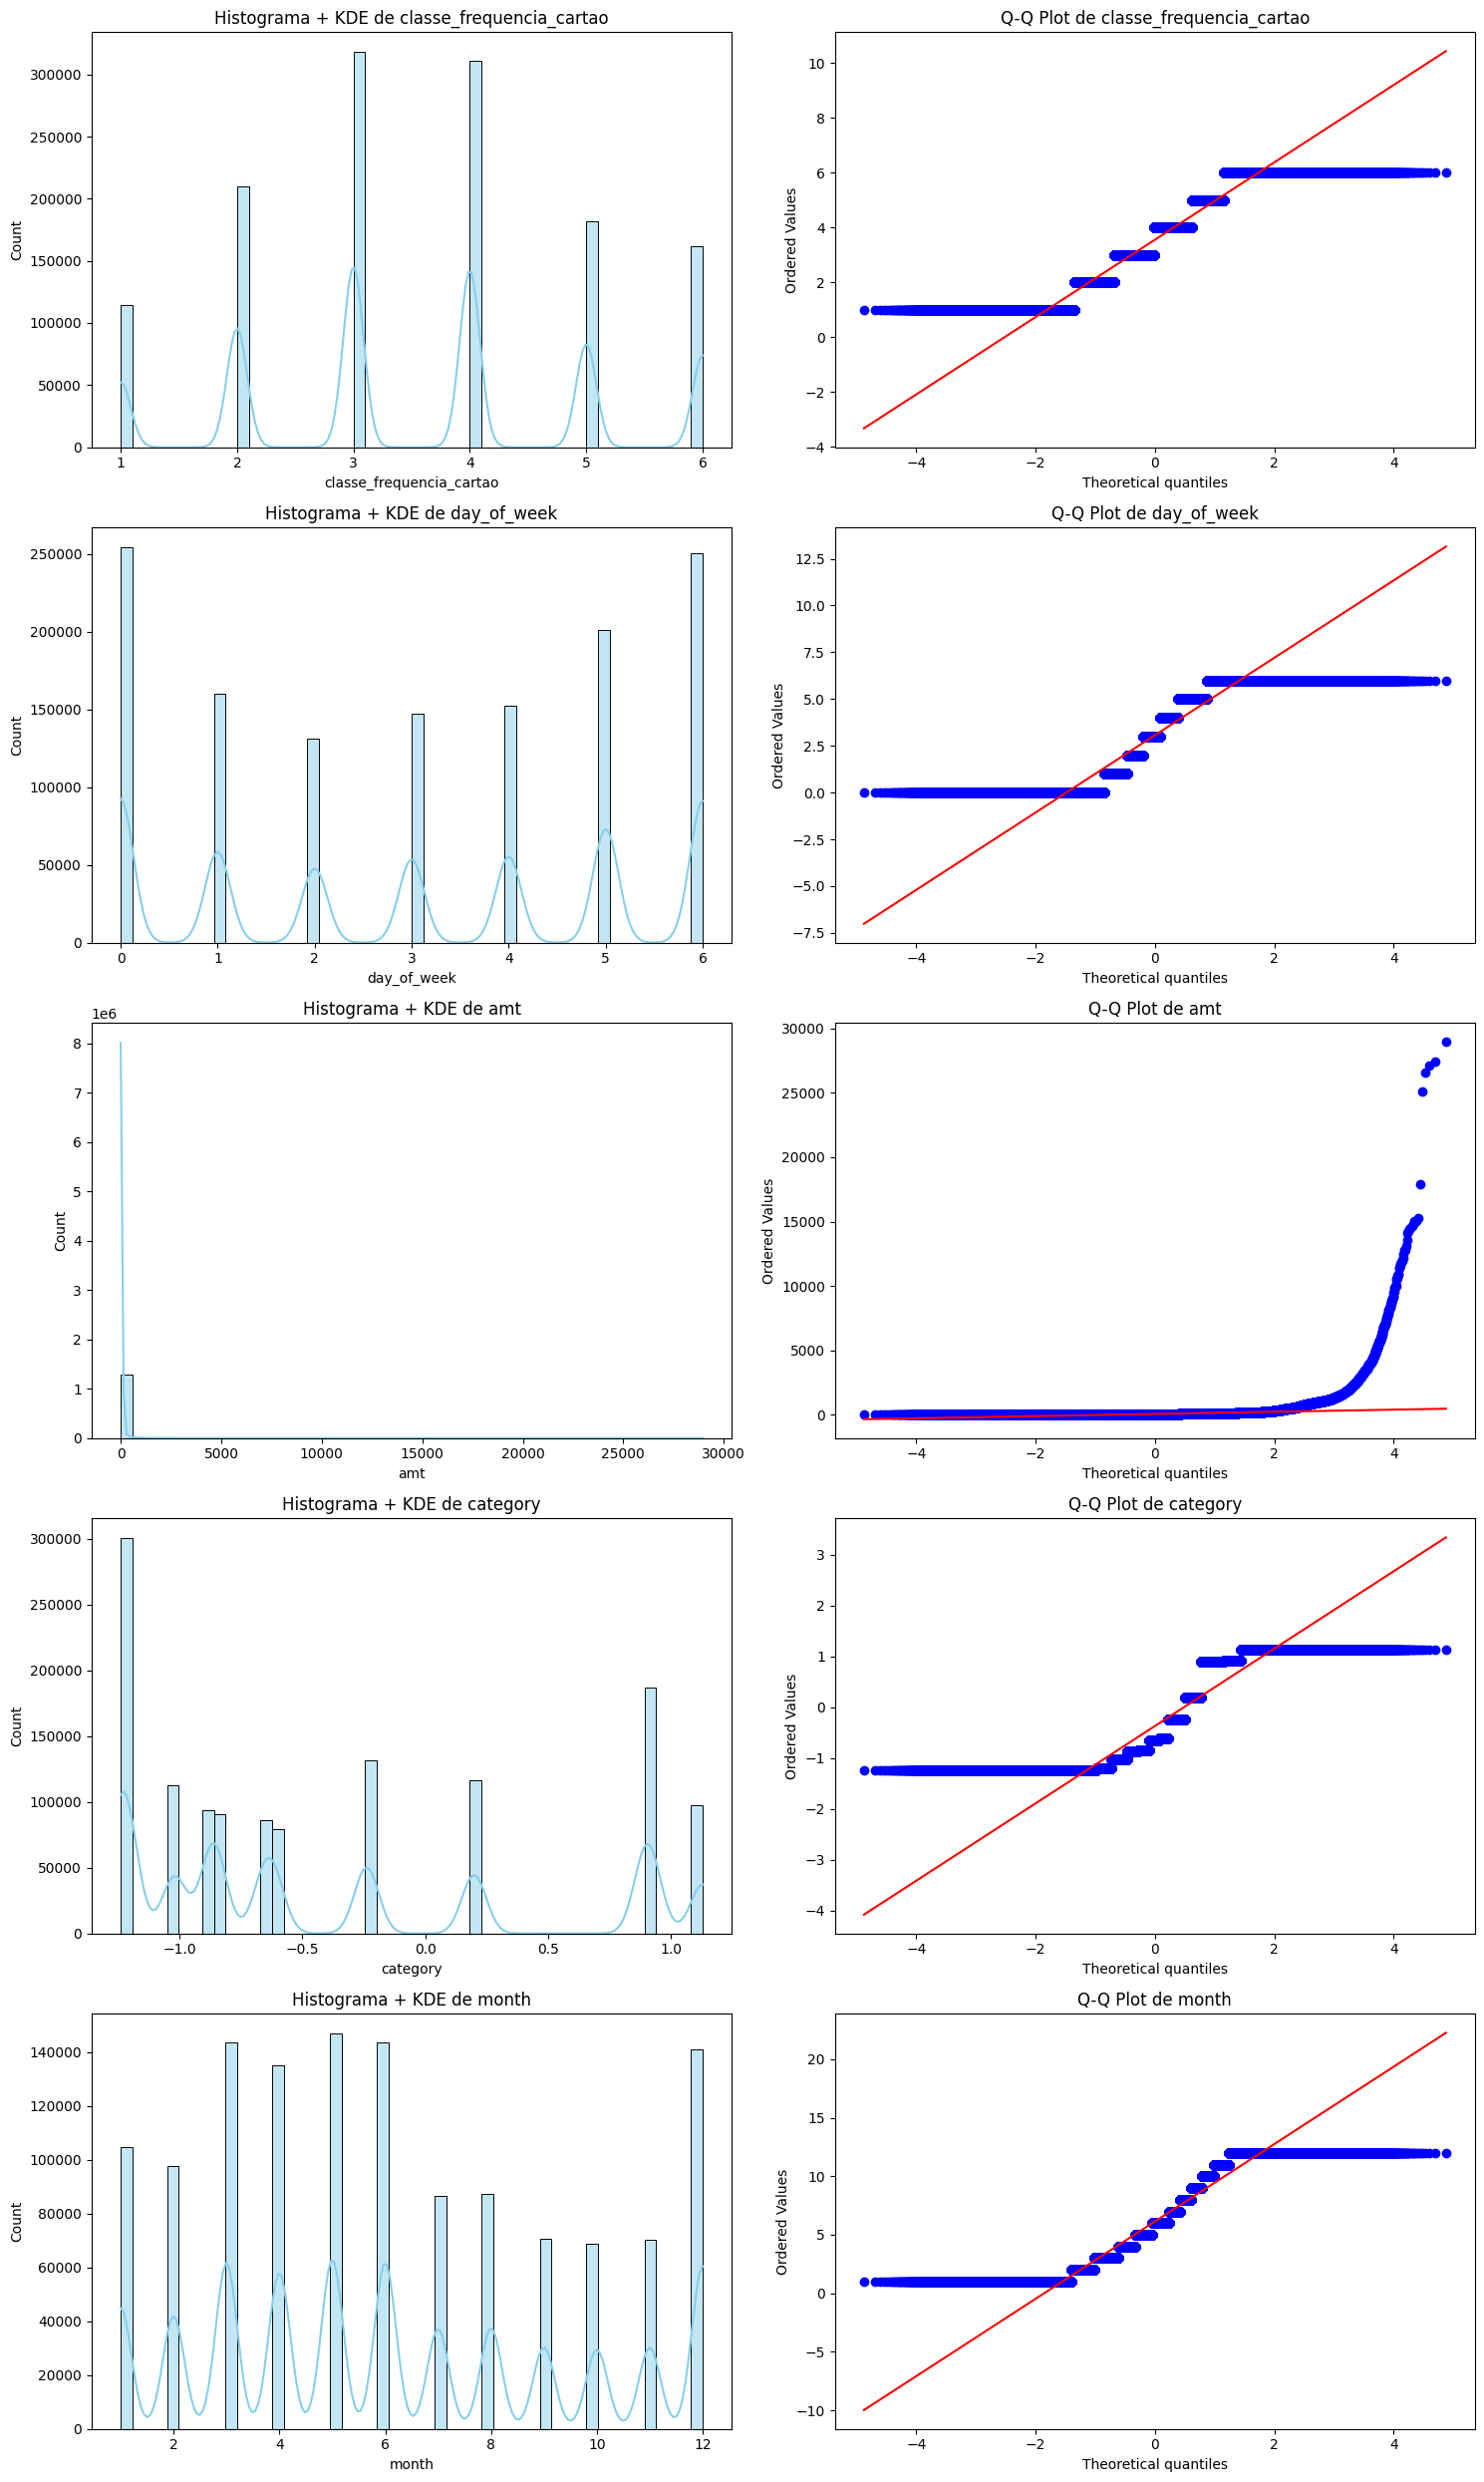

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

#testando a normalidade dados colunas numericas, 

numerical_cols = X_train.select_dtypes(include='number').columns.tolist() #lista de variaveis numericas


def analisar_normalidade(df, colunas):

    ''' 
    Funcao que analisa as variaveis numericas antes das trasnformacoes, principalmente para determinar qual tratamento de outlier
    sera necessario no momento das transformacoes do pipeline para essas varaiveis e a determinacao disso na classe de transformacao
    de outlier. Alem de melhorar a compreensao das variaveis.  

    '''
    n_cols = 2  # Número de colunas para os gráficos
    n_rows = (len(colunas) * 2 + 1) // n_cols  # Ajusta o número de linhas para acomodar todos os gráficos

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    axes = axes.flatten()  # Flatten para facilitar a indexação dos subgráficos

    for i, col in enumerate(colunas):
        ax_hist = axes[2 * i]  # Posição do histograma + KDE
        ax_qq = axes[2 * i + 1]  # Posição do Q-Q plot

        print(f"\n📊 Analisando a variável: {col}")
        print("-" * 50)
        
        # Teste de D’Agostino e Pearson
        try:
            stat, p_value = stats.normaltest(df[col].dropna())
            print(f"Estatística do teste (D’Agostino): {stat:.4f}")
            print(f"p-valor: {p_value:.4f}")
            if p_value > 0.05:
                print("✅ Parece seguir uma distribuição normal.")
            else:
                print("❌ Pode não seguir uma distribuição normal.")
        except Exception as e:
            print(f"Erro ao executar o teste D’Agostino: {e}")
            continue

        # Teste Anderson-Darling
        try:
            result = stats.anderson(df[col].dropna())
            print(f"Estatística do teste Anderson-Darling: {result.statistic:.4f}")
            print("Valores Críticos:", result.critical_values)
            print("Níveis de significância:", result.significance_level)
            if result.statistic < result.critical_values[2]:
                print("✅ Distribuição normal (nível de significância de 5%).")
            else:
                print("❌ A distribuição não é normal.")
        except Exception as e:
            print(f"Erro ao executar o teste Anderson-Darling: {e}")
            continue

        # Cálculo de skew (assimetria) e kurtosis (curtose)
        skew = df[col].dropna().skew()
        kurtosis = df[col].dropna().kurtosis()
        print(f"Assimetria (Skew): {skew:.4f}")
        print(f"Curtose (Kurtosis): {kurtosis:.4f}")

        # Plot Histograma + KDE
        sns.histplot(df[col].dropna(), kde=True, bins=50, color='skyblue', ax=ax_hist)
        ax_hist.set_title(f"Histograma + KDE de {col}")

        # Q-Q Plot
        stats.probplot(df[col].dropna(), dist="norm", plot=ax_qq)
        ax_qq.set_title(f"Q-Q Plot de {col}")

    # Ajustar layout
    plt.tight_layout()
    plt.show()


#analisando 
analisar_normalidade(X_train, numerical_cols)





In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
import pandas as pd





from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mapping_ = None

    def fit(self, X, y):
        col = X.columns[0]
        self.mapping_ = X[col].to_frame().join(pd.Series(y, name='target')).groupby(col)['target'].mean()
        return self

    def transform(self, X):
        X_transformed = X.copy()
        col = X.columns[0]
        X_transformed[col] = X_transformed[col].map(self.mapping_)
        X_transformed[col].fillna(0, inplace=True)
        return X_transformed






from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

class OneHotEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

    def fit(self, X, y=None):
        self.encoder.fit(X)
        return self

    def transform(self, X):
        encoded = self.encoder.transform(X)
        col_names = self.encoder.get_feature_names_out(X.columns)
        return pd.DataFrame(encoded, columns=col_names, index=X.index)







class OutlierFlagTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=3.0):
        self.threshold = threshold
        self.mean_ = None
        self.std_ = None

    def fit(self, X, y=None):
        self.mean_ = X.mean()
        self.std_ = X.std()
        return self

    def transform(self, X):
        z_scores = np.abs((X - self.mean_) / self.std_)
        outliers_flag = (z_scores > self.threshold).astype(int)
        outliers_flag.columns = [f"{col}_outlier" for col in X.columns]
        return outliers_flag
    



#ALTERNATIVA A SE TESTAR NO LUGAR DE OutlierFlagTransformer, POIS ELA E AFETADA PELA NORMALIDADE DAS VARAIVEIS POR CAUSA DA IMPLEMETNACAO COM BASE NO Z-SCORE 
class OutlierPercentilFlagTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, limites=(0.01, 0.01)):
        """
        Inicializa o transformador com limites inferiores e superiores para outliers, baseados em percentis.
        
        Parâmetros:
            limites (tuple): Limites inferiores e superiores para identificar outliers com base em percentis (ex: (0.01, 0.01) = 1%).
        """
        self.limites = limites
        self.percentis_ = None

    def fit(self, X, y=None):
        """
        Ajusta o transformador aos dados de entrada, calculando os percentis para cada variável numérica.
        
        Parâmetros:
            X (pd.DataFrame): Dados de entrada para ajuste (não é utilizado no cálculo, mas necessário para o fit).
        
        Retorna:
            self: O próprio transformador.
        """
        # Calculando os percentis para cada variável numérica
        self.percentis_ = {}
        for col in X.select_dtypes(include=[np.number]).columns:
            p_inf = X[col].quantile(self.limites[0])
            p_sup = X[col].quantile(1 - self.limites[1])
            self.percentis_[col] = (p_inf, p_sup)

        return self

    def transform(self, X):
        """
        Transforma os dados de entrada, criando flags binárias para os outliers com base em percentis.
        
        Parâmetros:
            X (pd.DataFrame): Dados a serem transformados, com os quais as flags de outliers serão geradas.
        
        Retorna:
            pd.DataFrame: DataFrame com as novas colunas de outliers adicionadas.
        """
        X_outliers = X.copy()
        
        for col, (p_inf, p_sup) in self.percentis_.items():
            nova_coluna = f'{col}_outlier'
            X_outliers[nova_coluna] = ((X_outliers[col] < p_inf) | (X_outliers[col] > p_sup)).astype(int)
        
        return X_outliers
    


from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders.woe import WOEEncoder

class WoeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        """
        cols: lista das colunas para aplicar o WOEEncoder.
        """
        self.cols = cols
        self.encoders_ = {}

    def fit(self, X, y):
        for col in self.cols:
            encoder = WOEEncoder()
            encoder.fit(X[col], y)
            self.encoders_[col] = encoder
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in self.cols:
            encoder = self.encoders_[col]
            X_transformed[col] = encoder.transform(X_transformed[col])
        return X_transformed





    

In [ ]:
from sklearn.pipeline import FeatureUnion, Pipeline
import optuna
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             roc_auc_score, balanced_accuracy_score, matthews_corrcoef)
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, balanced_accuracy_score, matthews_corrcoef
import optuna
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
import torch
import warnings
warnings.filterwarnings("ignore", message="A module that was compiled using NumPy 1.x cannot be run in NumPy 2.1.3")
 
#reclama por incompatibilidade com aversao do numpy antes e do numpy que o torch usa, se der problema mais pra 
# frente so comentar esse trecho, instalar as lib nas versoes novas e ser feliz 


# Verifica se há GPU disponível
use_gpu = torch.cuda.is_available()
device = "cuda" if use_gpu else "cpu"
tree_method_ = "gpu_hist" if use_gpu else "hist"

print(f"Usando GPU: {use_gpu}")
print(f"Método de árvore: {tree_method_}")



# TEMPLATE COMPLETO COM PIPELINE + OPTUNA (CLASSE RARA)


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, balanced_accuracy_score, matthews_corrcoef
import optuna
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import time


# ==================== Variáveis Globais ==================== 
threshold = 0.5
n_trials_ = 5
n_splits_ = 5

weights_skf = {
    'Accuracy': 0.0,          # Irrelevante em dados desbalanceados (pode mascarar a performance real)
    'f1': 0.05,               # Média harmônica entre precisão e recall (bom equilíbrio)
    'precision': 0.45,        # Indica a proporção de positivos corretos (penaliza falsos positivos)
    'recall': 0.35,           # Mede quantos positivos reais foram capturados (importante em fraudes)
    'auc': 0.05,              # Mede a capacidade geral de separação entre classes
    'balanced_acc': 0.0,      # Média das acurácias por classe (corrige o viés do desbalanceamento)
    'mcc': 0.1                # Avalia correlação entre predições e rótulos (robusto para desbalanceamento)
}


# ==================== Função de Geração de Folds e Treinamento ====================

def generate_folds_and_train(trial, X, y, pipeline, n_splits=n_splits_, smote=None):
    global weights_skf  # dicionário com os pesos de cada métrica

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    weighted_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        start_time = time.time()

        X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        y_train, y_val = y.iloc[train_idx].copy(), y.iloc[val_idx].copy()

        assert set(X.columns) == set(X_train.columns), "Colunas inconsistentes entre X e os folds!"

        if smote is not None:
            X_train, y_train = smote.fit_resample(X_train, y_train)

        pipeline.fit(X_train, y_train)
        probs = pipeline.predict_proba(X_val)[:, 1]
        preds = (probs >= threshold).astype(int)

        # Métricas individuais
        acc          = accuracy_score(y_val, preds)
        f1           = f1_score(y_val, preds)
        precision    = precision_score(y_val, preds, zero_division=0)
        recall       = recall_score(y_val, preds)
        auc          = roc_auc_score(y_val, probs)
        balanced_acc = balanced_accuracy_score(y_val, preds)
        mcc          = matthews_corrcoef(y_val, preds)

        # Score ponderado (forma explícita)
        fold_weighted_score = (
            weights_skf.get('Accuracy', 0)     * acc +
            weights_skf.get('f1', 0)           * f1 +
            weights_skf.get('precision', 0)    * precision +
            weights_skf.get('recall', 0)       * recall +
            weights_skf.get('auc', 0)          * auc +
            weights_skf.get('balanced_acc', 0) * balanced_acc +
            weights_skf.get('mcc', 0)          * mcc
        )

        weighted_scores.append(fold_weighted_score)

        elapsed = time.time() - start_time
        print(
            f"📁 Fold {fold}/{n_splits} | "
            f"Accuracy: {acc:.4f} | "
            f"F1: {f1:.4f} | "
            f"Precision: {precision:.4f} | "
            f"Recall: {recall:.4f} | "
            f"AUC: {auc:.4f} | "
            f"Balanced Acc: {balanced_acc:.4f} | "
            f"MCC: {mcc:.4f} | "
            f"Weighted Score: {fold_weighted_score:.4f} | "
            f"Tempo: {elapsed:.2f}s"
        )

    # Retorna a média das pontuações ponderadas calculadas para cada fold
    return np.mean(weighted_scores)





from sklearn.pipeline import FeatureUnion, Pipeline




# ==================== Funções Objetivo para Cada Modelo ====================

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

def build_pipeline(model):
    preprocessor = ColumnTransformer(transformers=[
        # Aplica WOE nas colunas especificadas
        ('woe', WoeTransformer(cols=['city', 'job', 'merchant', 'category']), ['city', 'job', 'merchant', 'category']),
        
        # Target Encoding
        ('target_enc', TargetEncoderTransformer(), ['bin']),
        
        # One-hot encoding para variáveis categóricas
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['period', 'gender']),
        
        # Flags de outliers baseados em percentis
        ('outliers_percentil', OutlierPercentilFlagTransformer(limites=(0.01, 0.01)), numerical_cols),
        
        # ('outliers', OutlierFlagTransformer(), numerical_cols),  # Alternativa com z-score (comentada)
    ])
    
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    return pipeline







def objective_xgb(trial):
    start_time = time.time()
    print(f"🚀 Iniciando trial {trial.number} para XGBoost...")
    model = XGBClassifier(
        objective='binary:logistic',
        tree_method=trial.suggest_categorical("tree_method", ["gpu_hist"]),
        use_label_encoder=False,
        eval_metric=trial.suggest_categorical("eval_metric", ["aucpr", "logloss"]),
        n_estimators=trial.suggest_int("n_estimators", 500, 3000),
        learning_rate=trial.suggest_float("learning_rate", 0.001, 0.05, log=True),
        max_depth=trial.suggest_int("max_depth", 3, 15),
        min_child_weight=trial.suggest_float("min_child_weight", 1, 20),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        gamma=trial.suggest_float("gamma", 0, 10),
        reg_alpha=trial.suggest_float("reg_alpha", 0, 5),
        reg_lambda=trial.suggest_float("reg_lambda", 0, 5),
        scale_pos_weight=trial.suggest_float("scale_pos_weight", 1, 10),
        random_state=42,
        n_jobs=-1
    )

    pipeline = build_pipeline(model)

    try:
        score = generate_folds_and_train(trial, X_train, y_train, pipeline)
        elapsed_time = time.time() - start_time
        print(f"✅ Trial {trial.number} finalizado | Score: {score:.4f} | Tempo: {elapsed_time:.2f} segundos")
        return score
    except Exception as e:
        elapsed_time = time.time() - start_time
        print(f"❌ Erro no trial {trial.number} | Tempo até o erro: {elapsed_time:.2f} segundos")
        print(f"Tipo de erro: {type(e).__name__} | Mensagem: {e}")
        raise e




def objective_knn(trial):
    start_time = time.time()
    print(f"🚀 Iniciando trial {trial.number} para KNN...")
    model = KNeighborsClassifier(
        n_neighbors=trial.suggest_int("n_neighbors", 3, 20),
        weights=trial.suggest_categorical("weights", ["uniform", "distance"]),
        p=trial.suggest_int("p", 1, 2)
    )

    pipeline = build_pipeline(model)

    try:
        score = generate_folds_and_train(trial, X_train, y_train, pipeline)
        elapsed_time = time.time() - start_time
        print(f"✅ Trial {trial.number} finalizado | Score: {score:.4f} | Tempo: {elapsed_time:.2f} segundos")
        return score
    except Exception as e:
        elapsed_time = time.time() - start_time
        print(f"❌ Erro no trial {trial.number} | Tempo até o erro: {elapsed_time:.2f} segundos")
        print(f"Tipo de erro: {type(e).__name__} | Mensagem: {e}")
        raise e



def objective_nn(trial):
    start_time = time.time()
    print(f"🚀 Iniciando trial {trial.number} para MLP...")
    model = MLPClassifier(
        hidden_layer_sizes=trial.suggest_int("hidden_layer_sizes", 50, 300),
        activation=trial.suggest_categorical("activation", ["relu", "tanh"]),
        solver=trial.suggest_categorical("solver", ["adam", "sgd"]),
        alpha=trial.suggest_float("alpha", 0.0001, 0.1, log=True),
        max_iter=500,
        random_state=42
    )

    pipeline = build_pipeline(model)

    try:
        score = generate_folds_and_train(trial, X_train, y_train, pipeline)
        elapsed_time = time.time() - start_time
        print(f"✅ Trial {trial.number} finalizado | Score: {score:.4f} | Tempo: {elapsed_time:.2f} segundos")
        return score
    except Exception as e:
        elapsed_time = time.time() - start_time
        print(f"❌ Erro no trial {trial.number} | Tempo até o erro: {elapsed_time:.2f} segundos")
        print(f"Tipo de erro: {type(e).__name__} | Mensagem: {e}")
        raise e



models = {
    "KNN": objective_knn,
    "XGBoost": objective_xgb,
    "NN": objective_nn
}

best_hyperparams = {}

def optimize_all_models():
    for model_name, objective_func in models.items():
        print(f"🔍 Iniciando otimização para o modelo: {model_name}")
        study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
        study.optimize(objective_func, n_trials=n_trials_)

        best_params = study.best_params
        best_hyperparams[model_name] = best_params

        print(f"📊 MELHORES HIPERPARÂMETROS PARA O MODELO {model_name}")
        print("═" * 60)
        for param, value in best_params.items():
            print(f"{param:<25}{value:<15}")
        print("═" * 60)


optimize_all_models()




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\jgeov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\jgeov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\traitlets\config\application.py", line 1075, in launch

Usando GPU: True
Método de árvore: gpu_hist
🔍 Iniciando otimização para o modelo: KNN
🚀 Iniciando trial 0 para KNN...
📁 Fold 1/5 | Accuracy: 0.9965 | F1: 0.6782 | Precision: 0.7192 | Recall: 0.6416 | AUC: 0.8900 | Balanced Acc: 0.8201 | MCC: 0.6775 | Weighted Score: 0.6943 | Tempo: 820.63s


# Treinamento Final

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, balanced_accuracy_score, matthews_corrcoef
from imblearn.over_sampling import SMOTE

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, 
    roc_auc_score, balanced_accuracy_score, matthews_corrcoef
)
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


# ==================== Funções auxilixares para modularizar ===================================

def evaluate_model_cv(pipeline, X, y, smote, threshold, n_splits=5):
    """
    Realiza a validação cruzada estratificada com cálculo de métricas para o modelo dado.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metric_sums = {
        'Accuracy': 0,
        'f1': 0,
        'precision': 0,
        'recall': 0,
        'auc': 0,
        'balanced_acc': 0,
        'mcc': 0
    }

    for train_idx, val_idx in skf.split(X, y):
        X_train_fold = X.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_train_fold = y.iloc[train_idx]
        y_val_fold = y.iloc[val_idx]

        if smote is not None:
            X_train_fold, y_train_fold = smote.fit_resample(X_train_fold, y_train_fold)

        pipeline.fit(X_train_fold, y_train_fold)
        probs = pipeline.predict_proba(X_val_fold)[:, 1]
        preds = (probs >= threshold).astype(int)

        metric_sums['Accuracy']     += accuracy_score(y_val_fold, preds)
        metric_sums['f1']           += f1_score(y_val_fold, preds)
        metric_sums['precision']    += precision_score(y_val_fold, preds, zero_division=0)
        metric_sums['recall']       += recall_score(y_val_fold, preds)
        metric_sums['auc']          += roc_auc_score(y_val_fold, probs)
        metric_sums['balanced_acc'] += balanced_accuracy_score(y_val_fold, preds)
        metric_sums['mcc']          += matthews_corrcoef(y_val_fold, preds)

    mean_metrics = {k: v / n_splits for k, v in metric_sums.items()}
    return mean_metrics


def print_metrics(model_name, metrics_dict):
    """
    Exibe as métricas médias de forma formatada.
    """
    print(f"📊 Métricas médias para o modelo {model_name}:")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value:.4f}")
    print("═" * 60)







# ==================== Função de Validacao dos modelos com os melhores hiperparâmetros encontrados ===================================

def validate_with_best_params(X_train, y_train, target, models, best_hyperparams, n_splits=n_splits_, smote=None, threshold=threshold):
    """
    Valida os modelos com os melhores hiperparâmetros encontrados pelo Optuna usando validação cruzada.

    Explicação:
    - Avalia a performance dos modelos nos dados de treino com validação cruzada (K-Folds).
    - Utiliza os melhores parâmetros de `Optuna` para cada modelo.
    - Calcula e retorna as métricas médias (AUC, precisão, F1, etc.) para cada modelo.
    """
    results = {}

    for model_name, model_func in models.items():
        print(f"🔍 Iniciando validação final para o modelo: {model_name}")
        best_params = best_hyperparams[model_name]

        if model_name == 'XGBoost':
            model = XGBClassifier(
                tree_method=best_params.get('tree_method', 'gpu_hist'),
                eval_metric=best_params['eval_metric'],
                n_estimators=best_params['n_estimators'],
                learning_rate=best_params['learning_rate'],
                max_depth=best_params['max_depth'],
                min_child_weight=best_params['min_child_weight'],
                subsample=best_params['subsample'],
                colsample_bytree=best_params['colsample_bytree'],
                gamma=best_params['gamma'],
                reg_alpha=best_params['reg_alpha'],
                reg_lambda=best_params['reg_lambda'],
                scale_pos_weight=best_params['scale_pos_weight'],
                use_label_encoder=False,
                random_state=42,
                n_jobs=-1
            )
        elif model_name == 'KNN':
            model = KNeighborsClassifier(
                n_neighbors=best_params['n_neighbors'],
                weights=best_params['weights'],
                p=best_params['p']
            )
        elif model_name == 'NN':
            model = MLPClassifier(
                hidden_layer_sizes=best_params['hidden_layer_sizes'],
                activation=best_params['activation'],
                solver=best_params['solver'],
                alpha=best_params['alpha'],
                random_state=42
            )
        else:
            model = model_func(**best_params)

        pipeline = build_pipeline(model)
        mean_metrics = evaluate_model_cv(pipeline, X_train, y_train, smote, threshold, n_splits)
        results[model_name] = mean_metrics
        print_metrics(model_name, mean_metrics)

    print("✅ Validação final completa para todos os modelos!")
    return results

# Aplicação da função com X_train e y_train
final_results = validate_with_best_params(X_train, y_train, target=target, models=models, best_hyperparams=best_hyperparams)





# ==================== Função de Treinamento final nos dados completos ====================
def train_and_apply_final_model(X_train, y_train, X_test, y_test, models, best_hyperparams):
    """
    Treinamento final nos dados completos e aplicação do modelo no conjunto de teste.
    Retorna um dicionário com as predições (treinamento e teste).
    """
    resultados_finais = {}

    for model_name, model_func in models.items():
        print(f"🚀 Aplicando modelo final no conjunto completo: {model_name}")
        best_params = best_hyperparams[model_name]

        # Tratamento específico para cada tipo de modelo
        if model_name == 'XGBoost':
            model = XGBClassifier(
                tree_method=best_params.get('tree_method', 'gpu_hist'),
                eval_metric=best_params['eval_metric'],
                n_estimators=best_params['n_estimators'],
                learning_rate=best_params['learning_rate'],
                max_depth=best_params['max_depth'],
                min_child_weight=best_params['min_child_weight'],
                subsample=best_params['subsample'],
                colsample_bytree=best_params['colsample_bytree'],
                gamma=best_params['gamma'],
                reg_alpha=best_params['reg_alpha'],
                reg_lambda=best_params['reg_lambda'],
                scale_pos_weight=best_params['scale_pos_weight'],
                use_label_encoder=False,
                random_state=42,
                n_jobs=-1
            )
        elif model_name == 'KNN':
            model = KNeighborsClassifier(
                n_neighbors=best_params['n_neighbors'],
                weights=best_params['weights'],
                p=best_params['p']
            )
        elif model_name == 'NN':
            model = MLPClassifier(
                hidden_layer_sizes=best_params['hidden_layer_sizes'],
                activation=best_params['activation'],
                solver=best_params['solver'],
                alpha=best_params['alpha'],
                random_state=42
            )
        else:
            raise ValueError(f"❌ Modelos não reconhecido! Verifique se os nomes estao corretos do dict de modelos.")
        



        # Criação do pipeline usando função modular
        pipeline = build_pipeline(model)

        # Treinamento final
        pipeline.fit(X_train, y_train)

        # Probabilidades de saída
        y_train_proba = pipeline.predict_proba(X_train)[:, 1]
        y_test_proba = pipeline.predict_proba(X_test)[:, 1]

        # Guarda no dicionário final
        resultados_finais[model_name] = {
            "y_train_true": y_train,
            "y_train_proba": y_train_proba,
            "y_test_true": y_test,
            "y_test_proba": y_test_proba
        }

    print("✅ Dicionário `resultados_finais` montado com sucesso!")
    return resultados_finais



# Aplicação da função com X_train, y_train, X_test e y_test
resultados_finais = train_and_apply_final_model(X_train, y_train, X_test, y_test, models=models, best_hyperparams=best_hyperparams)




In [ ]:
def avaliar_modelos_multiplos(resultados_modelos, threshold=threshold):
    """
    Avalia múltiplos modelos de classificação binária comparando curvas ROC, Precision-Recall e métricas.

    Parâmetros:
        resultados_modelos (dict): Dicionário com chaves como nomes dos modelos e valores contendo outro dict:
            {
                "modelo": nome,
                "y_train_true": array,
                "y_train_proba": array,
                "y_test_true": array,
                "y_test_proba": array
            }
        threshold (float): Limiar de corte para converter probabilidade em classe (default=0.5)
    """
    import matplotlib.pyplot as plt
    from sklearn.metrics import (
        roc_curve, roc_auc_score,
        precision_recall_curve, average_precision_score,
        confusion_matrix, ConfusionMatrixDisplay,
        accuracy_score, precision_score, recall_score, f1_score
    )

    # ===== CURVA ROC - Treino e Teste =====
    plt.figure(figsize=(7, 6))
    for nome_modelo, dados in resultados_modelos.items():
        # Curva ROC para o conjunto de teste
        fpr_test, tpr_test, _ = roc_curve(dados["y_test_true"], dados["y_test_proba"])
        auc_test = roc_auc_score(dados["y_test_true"], dados["y_test_proba"])
        plt.plot(fpr_test, tpr_test, lw=2, label=f"{nome_modelo} (AUC = {auc_test:.2f})")

        # Curva ROC para o conjunto de treino
        fpr_train, tpr_train, _ = roc_curve(dados["y_train_true"], dados["y_train_proba"])
        auc_train = roc_auc_score(dados["y_train_true"], dados["y_train_proba"])
        plt.plot(fpr_train, tpr_train, lw=1, linestyle='--', label=f"{nome_modelo} Treinamento (AUC = {auc_train:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.title("Curva ROC (Teste e Treino)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ===== PRECISION vs RECALL - Teste =====
    plt.figure(figsize=(7, 6))
    for nome_modelo, dados in resultados_modelos.items():
        precision, recall, _ = precision_recall_curve(dados["y_test_true"], dados["y_test_proba"])
        auc_pr = average_precision_score(dados["y_test_true"], dados["y_test_proba"])
        plt.plot(recall, precision, lw=2, label=f"{nome_modelo} (AUC-PR = {auc_pr:.2f})")

    plt.title("Precision vs Recall Curve (Teste)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ===== MATRIZ DE CONFUSÃO e MÉTRICAS por modelo =====
    for nome_modelo, dados in resultados_modelos.items():
        y_test_pred = (dados["y_test_proba"] >= threshold).astype(int)

        # Matriz de confusão
        cm = confusion_matrix(dados["y_test_true"], y_test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues", values_format="d")
        plt.title(f"Matriz de Confusão (Teste) - {nome_modelo}")
        plt.show()

        # Métricas
        accuracy = accuracy_score(dados["y_test_true"], y_test_pred)
        precision_val = precision_score(dados["y_test_true"], y_test_pred, zero_division=0)
        recall_val = recall_score(dados["y_test_true"], y_test_pred)
        f1 = f1_score(dados["y_test_true"], y_test_pred)
        auc_roc = roc_auc_score(dados["y_test_true"], dados["y_test_proba"])
        auc_pr = average_precision_score(dados["y_test_true"], dados["y_test_proba"])

        print(f"\n===== MÉTRICAS - {nome_modelo} =====")
        print(f"Acurácia:     {accuracy:.4f}")
        print(f"Precisão:     {precision_val:.4f}")
        print(f"Recall:       {recall_val:.4f}")
        print(f"F1-score:     {f1:.4f}")
        print(f"ROC AUC:      {auc_roc:.4f}")
        print(f"AUC Precision-Recall: {auc_pr:.4f}")

avaliar_modelos_multiplos(resultados_finais, threshold=0.5)



# TESTAR COM SELECAO DE FEATURES PELO MUTUAL IMPORTANCE

# EU MUDEI DE 20% DE TESTE PRA 30, PRA TESTAR SE O CONJUNTO DE TESTE COM MAIS DADOS E UNDERSAMPLING MELHORA 
# JA TENTEI TODOS OVERSAMPLING E NADA MELHOROU 

In [ ]:
print(X_train.shape[0], y_train.shape[0])
